# EDA- Graphics No Gaps

# Load Libraries

In [74]:
# Cargar librerias
from __future__ import absolute_import, division, print_function, unicode_literals
import os
from datetime import datetime
import datetime as dt  # Used to manage dates
import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")
import requests
import itertools # Create combinations of fields
import pymysql # Import MySql 
from sqlalchemy import create_engine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams 
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

import plotly.offline as py
from plotly import graph_objs as go
from plotly import figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots

import folium
import squarify

# Definir el ambiente de SQL
pymysql.install_as_MySQLdb()

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

%matplotlib inline
pd.plotting.register_matplotlib_converters()
pd.options.display.float_format = '{:.4f}'.format
rcParams.update({'figure.autolayout': True, 'figure.figsize':(12,10),'axes.titlesize':14})

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_info_rows', 100)

# Function Definitions

In [30]:
def save_data(df, file_name):
    # Write data to CSV File
    df.to_csv(path_or_buf=file_name, sep=',',index=False, encoding='utf-8')
    return

def read_data(file_name):
    df = pd.read_csv(file_name, sep=',', index_col=False, header='infer', float_precision=2)
    return df

def road_side_usage(calls):
    if calls > 0: return 1
    elif calls == 0: return 0
    else: return np.nan

# Re initiate all features and data
def reiniciar(file_name):
    df_household = read_data(file_name)
    
    # Regroup Group Income
    group1 = ['UNDER 10K','10-19,999' , '20-29,999', '30-39,999']
    group2 = ['40-49,999', '50-59,999', '60-69,999', '70-79,999', '80-89,999', '90-99,999']
    group3 = ['100-149,999', '150 - 174,999', '175 - 199,999', '200 - 249,999', '250K+' ]
    for i in group1:
        df_household['income']=np.where(df_household['income']== i, 'UNDER 39,999', df_household['income'])
    for i in group2:
        df_household['income']=np.where(df_household['income']== i, '40 - 99,999', df_household['income'])
    for i in group3:
        df_household['income']=np.where(df_household['income']== i, '100k+', df_household['income'])
    
    # Regroup tenures
    group1 = ['BETWEEN 6 & 10 YEARS', 'BETWEEN 11 & 15 YEARS', 
          'BETWEEN 16 & 20 YEARS', 'BETWEEN 1 & 5 YEARS', '< 1 YEAR']
    group2 = ['BETWEEN 31 & 40 YEARS', 'BETWEEN 21 & 30 YEARS']
    group3 = ['+40 YEARS']
    for i in group1:
        df_household['tenure']=np.where(df_household['tenure']== i, 'UNDER 20 YEARS', df_household['tenure'])
    for i in group2:
        df_household['tenure']=np.where(df_household['tenure']== i, 'BETWEEN 21 & 40 YEARS', df_household['tenure'])
    for i in group3:
        df_household['tenure']=np.where(df_household['tenure']== i, '+40 YEARS', df_household['tenure'])
    
    # Regroup credit ranges
    group1 = ['499 & LESS', '500-549','550-599','600-649', '650-699']
    group2 = ['700-749', '750-799']
    group3 = ['800+']
    for i in group1:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BELOW 700', df_household['credit_ranges'])
    for i in group2:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BETWEEN 700 & 799', df_household['credit_ranges'])
    for i in group3:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, '800+', df_household['credit_ranges'])
    
    # Regroup Education
    df_household['education']=np.where(df_household['education'] =='GRADUATED SCHOOL', 
                                   'COMPLETED COLLEGE', df_household['education']
                                  )
    # Regroup Race
    group1 = ['CAUCASION / WHITE - EUROPEAN', 'CAUCASION / WHITE - ENGLISH', 'CAUCASION / WHITE - WHITE NON-AMERICAN',
          'CAUCASION / WHITE - UNKNOWN', 'CAUCASION / WHITE - EASTERN EUROPEAN', 'CAUCASION / WHITE - JEWISH',
          'CAUCASION / WHITE - GREEK', 'CAUCASION / WHITE - DUTCH'
         ]
    group2 = ['HISPANIC - HISPANIC ORIGIN', 'HISPANIC - PORTUGUESE ORIGIN']
    group3 = ['ASIAN - CHINESE', 'ASIAN - UNKNOWN', 'ASIAN - JAPANESE', 'ASIAN - INDIAN', 'ASIAN - ORIENTAL']
    group4 = ['MIDDLE EASTERN - ARAB', 'MIDDLE EASTERN - EGYPTIAN']
    group5 = ['AFRICAN AMERICAN - AFRICAN ORIGIN', 'AMERICAN INDIAN']

    for i in group1:
        df_household['race']=np.where(df_household['race']== i, 'CAUCASION / WHITE', df_household['race'])
    for i in group2:
        df_household['race']=np.where(df_household['race']== i, 'HISPANIC', df_household['race'])
    for i in group3:
        df_household['race']=np.where(df_household['race']== i, 'ASIAN', df_household['race'])
    for i in group4:
        df_household['race']=np.where(df_household['race']== i, 'ARABS', df_household['race'])
    for i in group5:
        df_household['race']=np.where(df_household['race']== i, 'AMERICAN AFRICANS / INDIANS', df_household['race'])

    # Regroup Home Owner
    df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE RENTER', 'RENTER', df_household['home_owner'])
    df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE HOME OWNER', 'HOME OWNER', df_household['home_owner'])
    
    # Regroup Cancel reason
    group1 = ['NON-PAYMENT', 'ERS DECLINE CC', 'BAD ADD SET BY PO ACS', '*BAD CHECKS*', 
         ]
    group2 = ['DECEASED', 'NO LONGER DRIVING', 'MEMBERS REQUEST', 'CANCELLED DO NOT RENEW', 'TRANSFER MEMBER',
              'DO NOT RENEW', 'MOVED OUT OF TERR', 'TRANSFER MEMBER SUSPEND', 'CANCELLED MBRS REQUEST',
              'HEALTH ISSUE', 'NONCOMPLIANT AGE', 'PO RETURN'
             ]
    group3 = ['DATA PROBLEM','DUP MEMBERSHIP','ERS CNCL MSHIP PROGRAM','MANAGEMENT REQUEST', 'CANCEL PROCESS - FUTURE CANCEL DNR']

    for i in group1:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'PAYMENT ISSUES', df_household['cancel_reason'])
    for i in group2:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'MEMBER ISSUES', df_household['cancel_reason'])
    for i in group3:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'DATA/AAA ISSUES', df_household['cancel_reason'])

    # Regroup Mosaic Global household
    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'METROPOLITAN STRUGGLERS', 
                                                 'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                )

    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'SOPHISTICATED SINGLES', 
                                                     'BOURGEOIS PROSPERITY', df_household['mosaic_global_household']
                                                    )

    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'RURAL INHERITANCE', 
                                                     'CAREER AND FAMILY', df_household['mosaic_global_household']
                                                    )
    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'POST INDUSTRIAL SURVIVORS', 
                                                     'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                    )
    # Regroup Experian Group
    group1 = ['AUTUMN YEARS', 'GOLDEN YEAR GUARDIANS']
    group2 = ['BOOMING WITH CONFIDENCE', 'THRIVING BOOMERS', 'BLUE SKY BOOMERS']
    group3 = ['POWER ELITE', 'SURBURBAN STYLE', 'FLOURISHING FAMILIES']
    group4 = ['FAMILY UNION', 'MIDDLE CLASS MELTING POT', 'PROMISING FAMILIES', 'ECONOMIC CHALLENGES', 'FAMILIES IN MOTION',
              'PASTORAL PRIDE']
    group5 = ['SINGLES AND STARTERS', 'SIGNIFICANT SINGLES', 'YOUNG CITY SOLOS', 'CULTURAL CONNECTIONS',
             'ASPIRATIONAL FUSION']
    for i in group1:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'GOLDEN YEAR', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group2:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'BOOMERS', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group3:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'POWER ELITE', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group4:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'MIDDLE CLASS MELTING POT', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group5:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'SINGLES AND STARTERS', df_household['kcl_b_ind_mosaicsgrouping'])
    
    # Regroup Vehicle Manufaturer
    group1 = [ 'TOYOTA', 'FORD', 'HONDA', 'CHEVROLET', 'HYUNDAI', 'NISSAN', 'BUICK', 'SUBARU', 'SUZUKI',
         'DODGE', 'CHRYSLER', 'VOLKSWAGEN','KIA', 'MAZDA', 'SATURN', 'PONTIAC', 'SCION', 'MITSUBISHI',
          'GEO', 'CRYSLER', 'MG', 'FIAT', 'BICYCLE', 'ISUZU']
    group2 = ['JEEP', 'MERCURY','GMC', 'OLSMOBILE', 'RAM', 'PLYMOUTH', 'GENESIS', 'OLDSMOBILE', 'AMERICAN AUSTIN']
          
    group3 = ['LEXUS', 'VOLVO', 'MERCEDES-BENZ', 'CADILLAC','LINCOLN', 'ACURA', 'BMW', 'SAAB', 'AUDI', 'INFINITI',
          'LAND ROVER', 'MINI', 'JAGUAR', 'PORSCHE', 'HARLEY DAVIDSON', 'ALFA ROMEO']

    for i in group1:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'STANDARD END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
    for i in group2:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'MIDDLE END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
    for i in group3:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'LUXURY VEHICLE', df_household['sc_vehicle_manufacturer_name'])

    # Regroup Occupation Group
    group1 = ['PROFESSIONAL - KNOWN', 'PROFESSIONAL - INFERRED', 'OFFICE ADMINISTRATION - KNOWN',
         'SALES - KNOWN', 'OFFICE ADMINISTRATION - INFERRED', 'TECHNICAL - INFERRED',
         'SALES - INFERRED', 'TECHNICAL - KNOWN']
    group2 = ['MANAGEMENT - KNOWN', 'BLUE COLLAR - KNOWN', 'MANAGEMENT - INFERRED', 'BLUE COLLAR - INFERRED']
    group3 = ['RETIRED - INFERRED', 'RETIRED - KNOWN']
    group4 = ['OTHER - INFERRED', 'OTHER - KNOWN']

    for i in group1:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'PROFESSIONAL', df_household['occupation_group'])
    for i in group2:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'MANAGEMENT', df_household['occupation_group'])
    for i in group3:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'RETIRED', df_household['occupation_group'])
    for i in group4:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'OTHER', df_household['occupation_group'])

    # Regroup Total members inside a household
    df_household['no_members'] = ' '
    df_household['no_members']=np.where(df_household['total_members_in_household']== 1, '1 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 2, '2 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 3, '3 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 4, '4 - MEMBER', 
                                        df_household['no_members'])

    df_household['no_members']=np.where(df_household['total_members_in_household']> 4, '5 - MEMBER', 
                                        df_household['no_members'])
    group5 = np.arange(5,20,1)
    for i in group5:
        df_household['no_members']=np.where(df_household['total_members_in_household']== i, '+5 - MEMBER', 
                                        df_household['no_members'])
    
    # Create roadside usage
    df_household['use_road_side'] = df_household['total_calls'].apply(lambda x:road_side_usage(x))
    df_household.consumer_score = np.where(df_household.consumer_score!= np.nan, 1/df_household.consumer_score, 
                                        df_household.consumer_score)
    df_household.consumer_score = np.where(~(df_household.consumer_score > 0), df_household.consumer_score.mean(), 
                                           df_household.consumer_score)
    
    # create feature Cancel = 1 - member cancelled, if 0 active member
    df_household['aaa_cancel'] = 1
    df_household['aaa_cancel']=np.where(df_household['member_status']== 'ACTIVE', 0, 
                                        df_household['aaa_cancel'])
    df_household['aaa_cancel']=np.where(df_household['member_status']== 'PENDING', 0, 
                                        df_household['aaa_cancel'])
    df_household['aaa_cancel']=np.where(df_household['member_status']== 'CANCELLED', 1, 
                                        df_household['aaa_cancel'])
    return df_household

# Load Data

* CREATE 
    ALGORITHM = UNDEFINED 
    DEFINER = `root`@`localhost` 
    SQL SECURITY DEFINER
VIEW `capstone_ai`.`household_view` AS
    SELECT 
        `a`.`membership_id` AS `membership_id`,
        `a`.`household_key` AS `household_key`,
        `a`.`income` AS `income`,
        `a`.`member_status` AS `member_status`,
        `a`.`state_grouped` AS `state_grouped`,
        `a`.`credit_ranges` AS `credit_ranges`,
        `a`.`cancel_reason` AS `cancel_reason`,
        `a`.`renew_method` AS `renew_method`,
        `a`.`plus_indicator_description` AS `plus_indicator_description`,
        `a`.`zip` AS `zip`,
        `a`.`sc_vehicle_manufacturer_name` AS `sc_vehicle_manufacturer_name`,
        `a`.`sc_vehicle_model_name` AS `sc_vehicle_model_name`,
        `a`.`race` AS `race`,
        `a`.`home_owner` AS `home_owner`,
        `a`.`education` AS `education`,
        `a`.`dwelling_type` AS `dwelling_type`,
        `a`.`gender` AS `gender`,
        `a`.`occupation_code` AS `occupation_code`,
        `a`.`occupation_group` AS `occupation_group`,
        `a`.`occupant_type` AS `occupant_type`,
        `a`.`mosaic_household` AS `mosaic_household`,
        `a`.`mosaic_global_household` AS `mosaic_global_household`,
        `a`.`kcl_b_ind_mosaicsgrouping` AS `kcl_b_ind_mosaicsgrouping`,
        `a`.`generation` AS `generation`,
        `a`.`tenure` AS `tenure`,
        `a`.`no_tenure` AS `aaa_no_tenure`,
        MAX(`a`.`member_tenure_years`) AS `aaa_member_tenure_years`,
        AVG(`a`.`age`) AS `aaa_mean_age`,
        AVG(`a`.`length_of_residence`) AS `length_of_residence`,
        MAX(`a`.`fsv_cmsi_flag`) AS `aaa_mortgage`,
        MAX(`a`.`fsv_credit_card_flag`) AS `aaa_credit_card`,
        MAX(`a`.`fsv_deposit_program_flag`) AS `aaa_deposit`,
        MAX(`a`.`fsv_home_equity_flag`) AS `aaa_home_equity`,
        MAX(`a`.`fsv_cmsi_flag`) AS `aaa_financial_service`,
        MAX(`a`.`ins_client_flag`) AS `aaa_auto_insurance`,
        MAX(`a`.`fsv_id_theft_flag`) AS `aaa_id_theft`,
        MAX(`a`.`motorcycle_indicator`) AS `aaa_motorcycle_indicator`,
        MAX(`a`.`trv_globalware_flag`) AS `aaa_travel`,
        AVG(`a`.`no_child`) AS `aaa_mean_child`,
        AVG(`a`.`total_cost`) AS `aaa_mean_total_cost`,
        MAX(`a`.`no_race`) AS `aaa_no_race`,
        MAX(`a`.`no_home_owner`) AS `aaa_no_home_owner`,
        MAX(`a`.`no_education`) AS `aaa_no_education`,
        MAX(`a`.`no_income`) AS `aaa_no_income`,
        MAX(`a`.`no_dwelling_type`) AS `aaa_no_dwelling_type`,
        MAX(`a`.`no_credit_ranges`) AS `aaa_no_credit_ranges`,
        MAX(`a`.`no_gender`) AS `aaa_no_gender`,
        MAX(`a`.`no_language`) AS `aaa_no_language`,
        MAX(`a`.`no_reason_joined`) AS `aaa_no_reason_joined`,
        MAX(`a`.`no_cancel_reason`) AS `aaa_cancel_reason`,
        MAX(`a`.`no_mosaic_household`) AS `aaa_no_mosaic_household`,
        MAX(`a`.`no_mosaic_global_household`) AS `aaa_no_mosaic_global_household`,
        MAX(`a`.`no_kcl_b_ind_mosaicsgrouping`) AS `aaa_no_kcl_b_ind_mosaicsgrouping`,
        MAX(`a`.`no_occupation_code`) AS `aaa_no_occupation_code`,
        MAX(`a`.`no_occupation_group`) AS `aaa_no_occupation_group`,
        MAX(`a`.`no_occupant_type`) AS `aaa_no_occupant_type`,
        MAX(`a`.`no_plus_indicator_description`) AS `aaa_no_plus_indicator_description`,
        MAX(`a`.`no_generation`) AS `aaa_no_generation`,
        SUM(`a`.`ers_ent_count_year_1`) AS `total_calls_year_1`,
        SUM(`a`.`ers_ent_count_year_2`) AS `total_calls_year_2`,
        SUM(`a`.`ers_ent_count_year_3`) AS `total_calls_year_3`,
        SUM(`a`.`ers_member_cost_year_1`) AS `total_member_cost_1`,
        SUM(`a`.`ers_member_cost_year_2`) AS `total_member_cost_2`,
        SUM(`a`.`ers_member_cost_year_3`) AS `total_member_cost_3`,
        SUM(`a`.`basic_cost`) AS `basic_cost`,
        SUM(`a`.`plus_cost`) AS `plus_cost`,
        SUM(`a`.`premier_cost`) AS `premier_cost`,
        AVG(`a`.`basic_cost`) AS `mean_basic_cost`,
        AVG(`a`.`plus_cost`) AS `mean_plus_cost`,
        AVG(`a`.`premier_cost`) AS `mean_premier_cost`,
        SUM(((`a`.`ers_ent_count_year_1` + `a`.`ers_ent_count_year_2`) + `a`.`ers_ent_count_year_3`)) AS `total_calls`,
        SUM(((`a`.`ers_member_cost_year_1` + `a`.`ers_member_cost_year_2`) + `a`.`ers_member_cost_year_3`)) AS `total_member_cost`,
        AVG(((`a`.`ers_member_cost_year_1` + `a`.`ers_member_cost_year_2`) + `a`.`ers_member_cost_year_3`)) AS `mean_total_member_cost`,
        CONCAT(`a`.`sc_vehicle_manufacturer_name`,
                ' ',
                `a`.`sc_vehicle_model_name`) AS `vehicle`,
        SUM(`a`.`total_cost`) AS `total_cost`,
        AVG(`a`.`total_cost`) AS `mean_total_cost`,
        COUNT(DISTINCT `a`.`member_number_associate_id`) AS `total_members_in_household`
    FROM
        `capstone_ai`.`capstone_aaa_featured` `a`
    GROUP BY `a`.`membership_id`
    ORDER BY `a`.`membership_id`

# Load data from the View

In [31]:
# Load data from the View create using Capstone AAA - EDA .ipynb
df_feature = reiniciar('household_view.csv')
df_capstone_aaa_f = pd.read_csv('capstone_aaa_featured.csv', sep=',',
                               parse_dates=['sc_date', 'birth_date_mmddyyyy', 'call_status_recv_date',
                                  'date_of_birth','active_expiration_date', 'cancel_date',
                                  'join_aaa_date', 'join_club_date', 'reinstate_date'], 
                                infer_datetime_format=True, float_precision=2
                               )


In [32]:
df_feature.head()

membership_id  household_key        income member_status state_grouped  \
0            153        4500791  UNDER 39,999        ACTIVE            RI   
1            155        4317516       UNKNOWN     CANCELLED            RI   
2            163       11622991   40 - 99,999        ACTIVE            RI   
3            182         579810   40 - 99,999        ACTIVE            RI   
4            188        7187017         100k+        ACTIVE            RI   

       credit_ranges  cancel_reason renew_method plus_indicator_description  \
0          BELOW 700        UNKNOWN   AUTO RENEW           BASIC MEMBERSHIP   
1            UNKNOWN  MEMBER ISSUES       NOTICE                    UNKNOWN   
2  BETWEEN 700 & 799        UNKNOWN   AUTO RENEW           BASIC MEMBERSHIP   
3          BELOW 700        UNKNOWN       NOTICE           BASIC MEMBERSHIP   
4          BELOW 700        UNKNOWN       NOTICE           BASIC MEMBERSHIP   

    zip sc_vehicle_manufacturer_name sc_vehicle_model_name               race  \
0  2893         STANDARD END VEHICLE                 CAMRY  CAUCASION / WHITE   
1  2878                      UNKNOWN               UNKNOWN            UNKNOWN   
2  2889         STANDARD END VEHICLE                   BRZ           HISPANIC   
3  2863               LUXURY VEHICLE                  QX56  CAUCASION / WHITE   
4  2888         STANDARD END VEHICLE               SEBRING  CAUCASION / WHITE   

   home_owner     education                             dwelling_type  \
0  HOME OWNER  SOME COLLEGE  SMALL OR LARGE MULTI-FAMILY W/APT NUMBER   
1     UNKNOWN       UNKNOWN                                      SFDU   
2  HOME OWNER       UNKNOWN                                      SFDU   
3  HOME OWNER  SOME COLLEGE                                      SFDU   
4  HOME OWNER       UNKNOWN                                      SFDU   

    gender occupation_code occupation_group occupant_type    mosaic_household  \
0  UNKNOWN         UNKNOWN          UNKNOWN       UNKNOWN    SENIOR DISCOUNTS   
1  UNKNOWN         UNKNOWN          UNKNOWN       UNKNOWN      AGING IN PLACE   
2  UNKNOWN         UNKNOWN          UNKNOWN       UNKNOWN  NO PLACE LIKE HOME   
3     MALE         RETIRED          RETIRED       UNKNOWN         TOWN ELDERS   
4   FEMALE         UNKNOWN          RETIRED       UNKNOWN      AGING IN PLACE   

   mosaic_global_household kcl_b_ind_mosaicsgrouping  \
0        LOW INCOME ELDERS               GOLDEN YEAR   
1   COMFORTABLE RETIREMENT               GOLDEN YEAR   
2  ROUTINE SERVICE WORKERS                   BOOMERS   
3   COMFORTABLE RETIREMENT               GOLDEN YEAR   
4   COMFORTABLE RETIREMENT               GOLDEN YEAR   

                 generation          tenure  aaa_no_tenure  \
0         POST-WAR (< 1948)       +40 YEARS              0   
1                   UNKNOWN  UNDER 20 YEARS              1   
2  MILLENIALS (1981 - 1993)  UNDER 20 YEARS              6   
3         POST-WAR (< 1948)       +40 YEARS              0   
4         POST-WAR (< 1948)  UNDER 20 YEARS              6   

   aaa_member_tenure_years  aaa_mean_age  length_of_residence  aaa_mortgage  \
0                       49       97.0000              15.0000             0   
1                       13           nan               0.0000             0   
2                       59       47.6667               8.5556             0   
3                       59       83.0000              15.0000             0   
4                       49       63.1667              15.0000             0   

   aaa_credit_card  aaa_deposit  aaa_home_equity  aaa_financial_service  \
0                1            0                0                      0   
1                0            0                0                      0   
2                0            0                0                      0   
3                0            0                0                      0   
4                0            0                0                      0   

   aaa_auto_insu

In [33]:
df_capstone_aaa_f.head(5)

individual_key  household_key  member_flag          city state_grouped  \
0        52211550        4500791            1  WEST WARWICK            RI   
1        52211550        4500791            1  WEST WARWICK            RI   
2        52211550        4500791            1  WEST WARWICK            RI   
3        52211550        4500791            1  WEST WARWICK            RI   
4        52211550        4500791            1  WEST WARWICK            RI   

   zip5      zip9  fsv_cmsi_flag  fsv_credit_card_flag  \
0  2893  28933850              0                     1   
1  2893  28933850              0                     1   
2  2893  28933850              0                     1   
3  2893  28933850              0                     1   
4  2893  28933850              0                     1   

   fsv_deposit_program_flag  fsv_home_equity_flag  fsv_id_theft_flag  \
0                         0                     0                  0   
1                         0                     0                  0   
2                         0                     0                  0   
3                         0                     0                  0   
4                         0                     0                  0   

   fsv_mortgage_flag  ins_client_flag  trv_globalware_flag number_of_children  \
0                  0                0                    0          ONE CHILD   
1                  0                0                    0          ONE CHILD   
2                  0                0                    0          ONE CHILD   
3                  0                0                    0          ONE CHILD   
4                  0                0                    0          ONE CHILD   

  responded_to_catalog                         race  length_of_residence  \
0              UNKNOWN  CAUCASION / WHITE - ENGLISH                   15   
1              UNKNOWN  CAUCASION / WHITE - ENGLISH                   15   
2              UNKNOWN  CAUCASION / WHITE - ENGLISH                   15   
3              UNKNOWN  CAUCASION / WHITE - ENGLISH                   15   
4              UNKNOWN  CAUCASION / WHITE - ENGLISH                   15   

  mail_responder  home_owner     income date_of_birth children     education  \
0            YES  HOME OWNER  30-39,999    1922-02-05      YES  SOME COLLEGE   
1            YES  HOME OWNER  30-39,999    1922-02-05      YES  SOME COLLEGE   
2            YES  HOME OWNER  30-39,999    1922-02-05      YES  SOME COLLEGE   
3            YES  HOME OWNER  30-39,999    1922-02-05      YES  SOME COLLEGE   
4            YES  HOME OWNER  30-39,999    1922-02-05      YES  SOME COLLEGE   

                              dwelling_type credit_ranges language   gender  \
0  SMALL OR LARGE MULTI-FAMILY W/APT NUMBER       600-649  ENGLISH  UNKNOWN   
1  SMALL OR LARGE MULTI-FAMILY W/APT NUMBER       600-649  ENGLISH  UNKNOWN   
2  SMALL OR LARGE MULTI-FAMILY W/APT NUMBER       600-649  ENGLISH  UNKNOWN   
3  SMALL OR LARGE MULTI-FAMILY W/APT NUMBER       600-649  ENGLISH  UNKNOWN   
4  SMALL OR LARGE MULTI-FAMILY W/APT NUMBER       600-649  ENGLISH  UNKNOWN   

  active_expiration_date bad_address_flag billing_code_description  \
0             2020-09-01                F               NEW MEMBER   
1             2020-09-01                F               NEW MEMBER   
2             2020-09-01                F               NEW MEMBER   
3             2020-09-01                F               NEW MEMBER   
4             2020-09-01                F               NEW MEMBER   

  birth_date_mmddyyyy          branch_name cancel_date cancel_reason county  \
0          1922-02-05  RI - WARWICK BRANCH         NaT       UNKNOWN   KENT   
1          1922-02-05  RI - WARWICK BRANCH         NaT       UNKNOWN   KENT   
2          1922-02-05  RI - WARWICK BRANCH         NaT       UNKNOWN   KENT   
3          1922-02-05  RI - WARWICK BRANCH         NaT       UNKNOWN   KENT   
4          1922-02-05  RI - WARWICK BRANCH

# Plot number of members to calls to AAA for services - all member status.

In [63]:
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5261 entries, 0 to 5260
Data columns (total 89 columns):
membership_id                        int64
household_key                        int64
income                               object
member_status                        object
state_grouped                        object
credit_ranges                        object
cancel_reason                        object
renew_method                         object
plus_indicator_description           object
zip                                  int64
sc_vehicle_manufacturer_name         object
sc_vehicle_model_name                object
race                                 object
home_owner                           object
education                            object
dwelling_type                        object
gender                               object
occupation_code                      object
occupation_group                     object
occupant_type                        object
mosaic_household

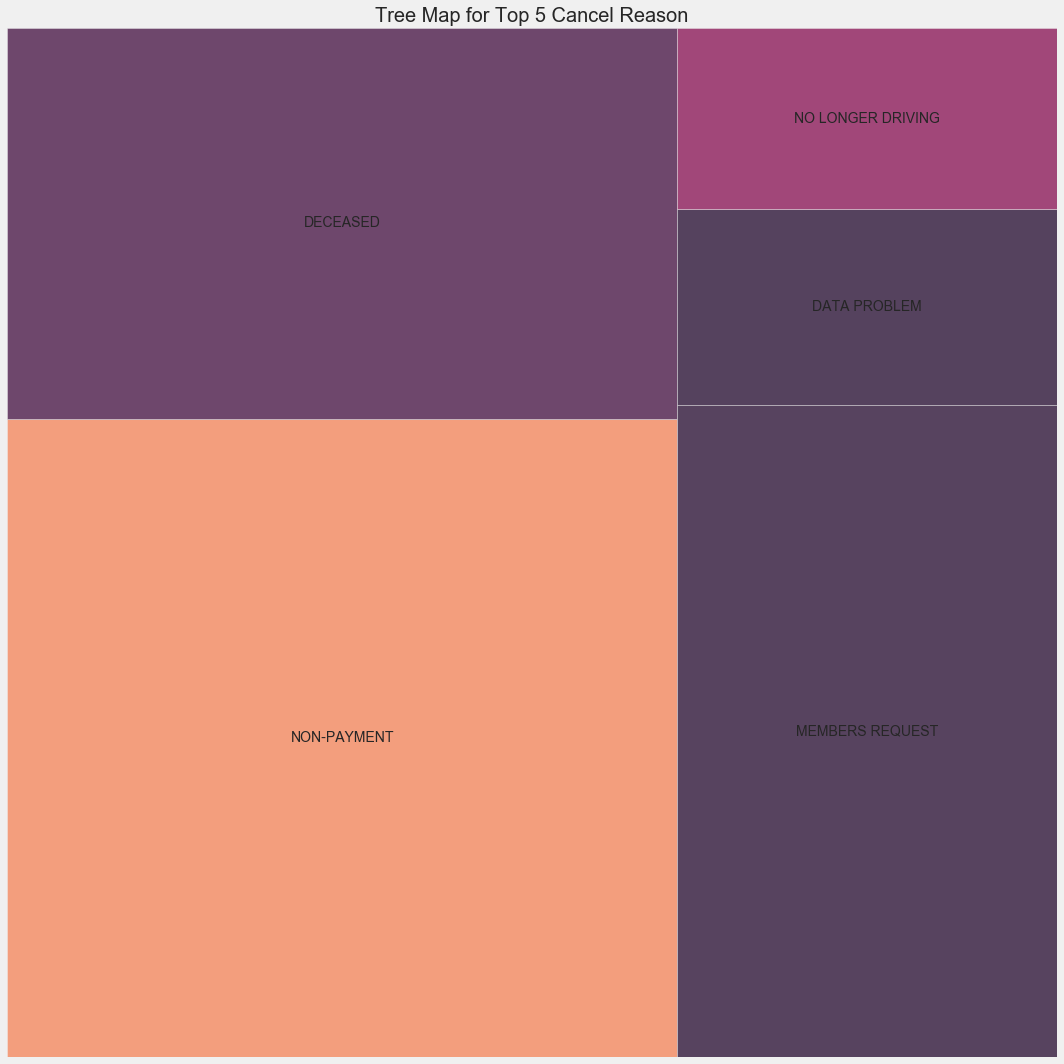

In [85]:
# plotting a tree map
df = df_capstone_aaa_f[df_capstone_aaa_f['cancel_reason']!='UNKNOWN']
y = df['cancel_reason'].value_counts().head(5)
    
plt.rcParams['figure.figsize'] = (15, 15)
plt.style.use('fivethirtyeight')

#color = plt.cm.magma(np.linspace(0, 1, 15))
squarify.plot(sizes = y.values, label = y.index, alpha=.8)
plt.title('Tree Map for Top 5 Cancel Reason', fontsize = 20)

plt.axis('off')
plt.show()


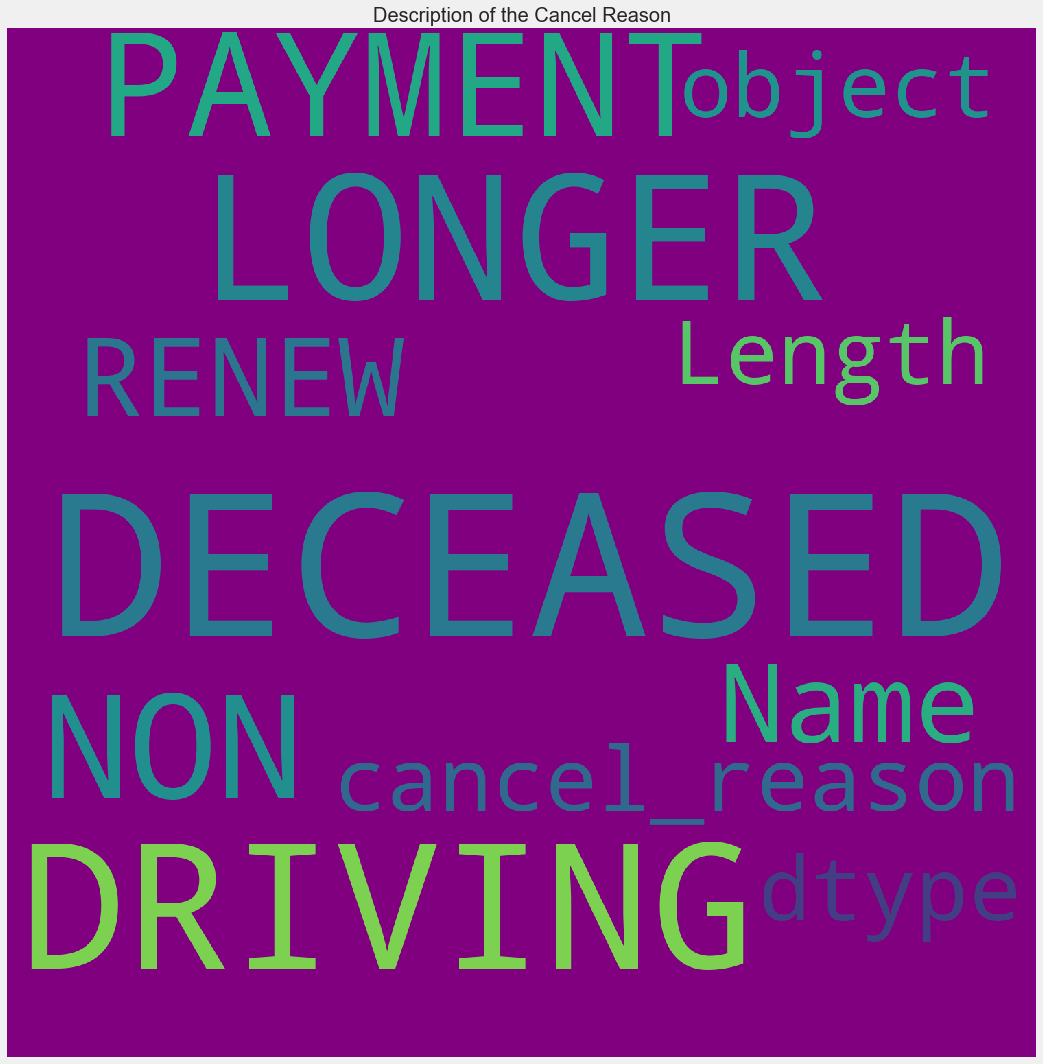

In [91]:
from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (15, 15)
plt.style.use('fast')

wc = WordCloud(background_color = 'purple', width = 1500, height = 1500).generate(str(df['cancel_reason']))
plt.title('Description of the Cancel Reason', fontsize = 20)

plt.imshow(wc)
plt.axis('off')
plt.show()

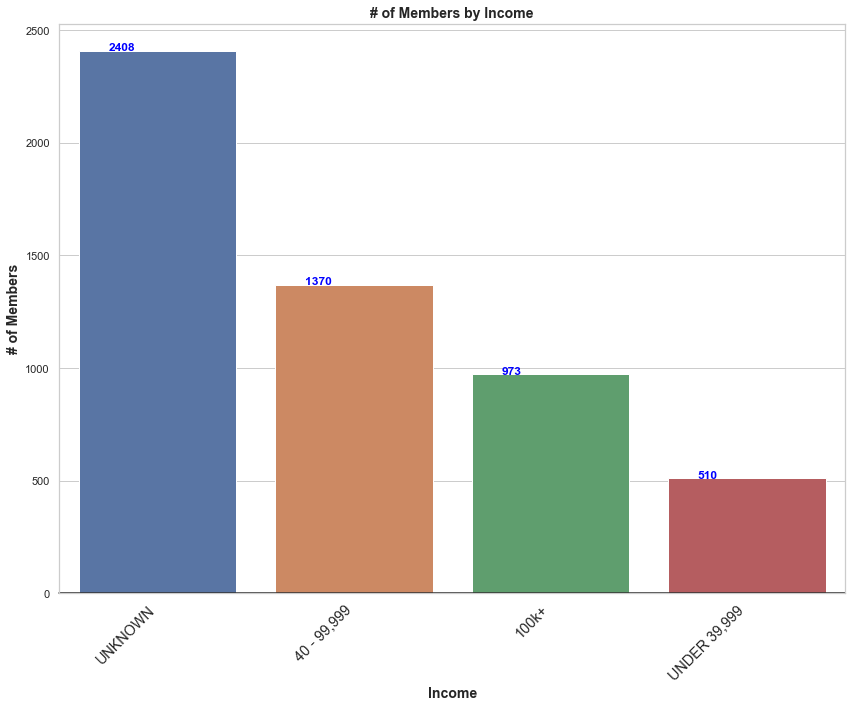

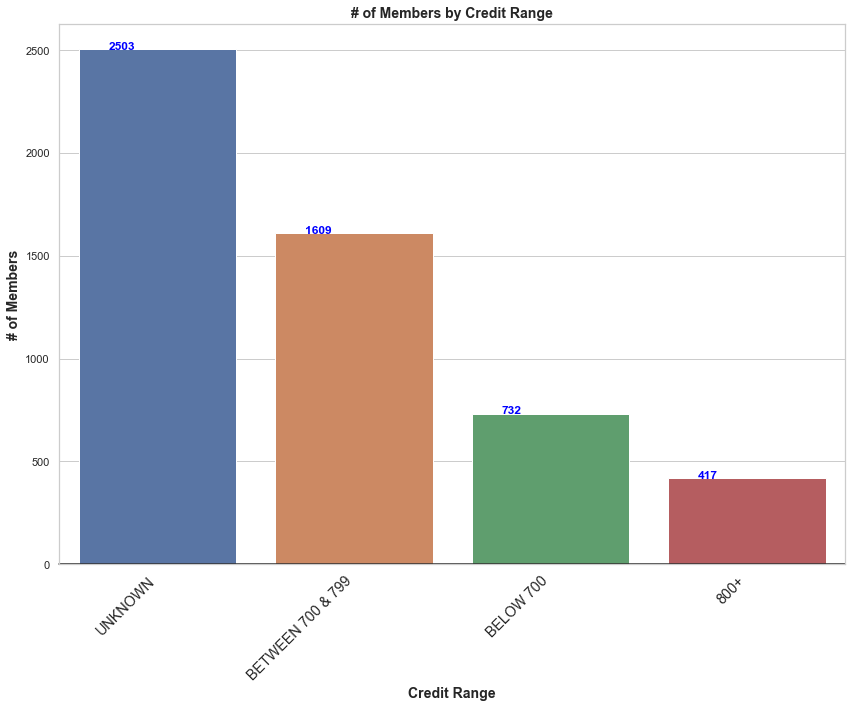

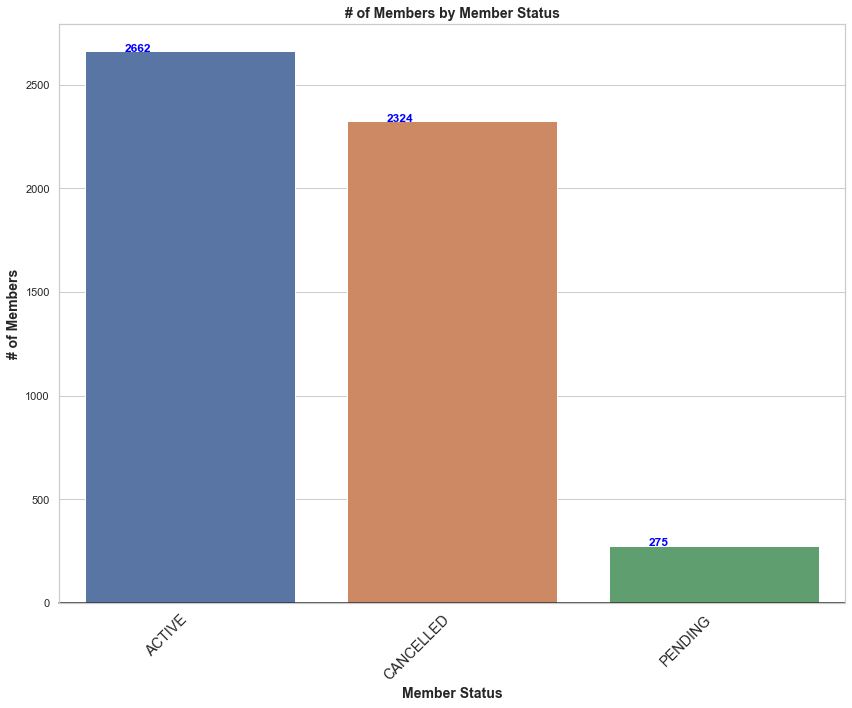

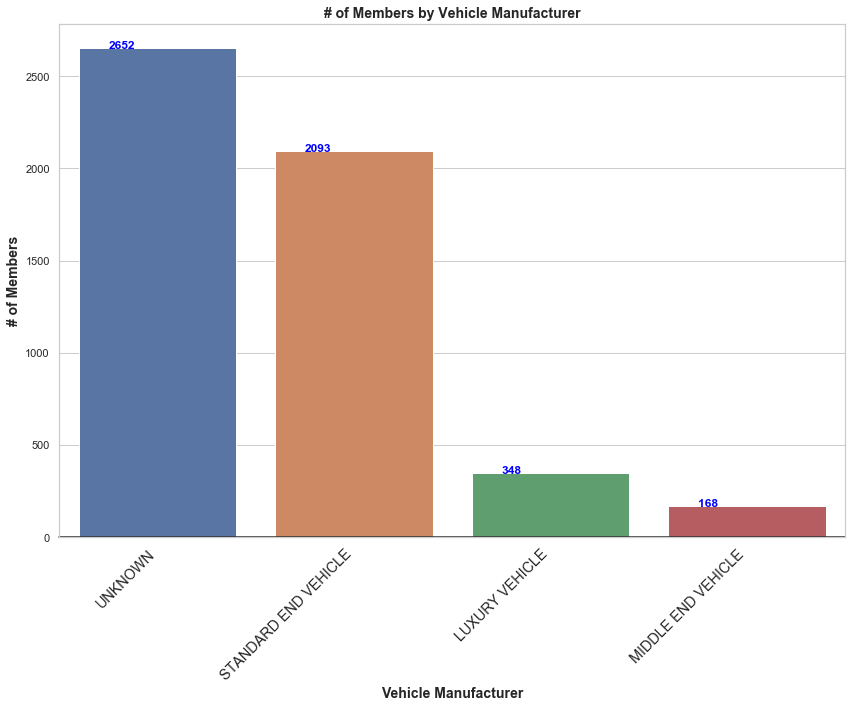

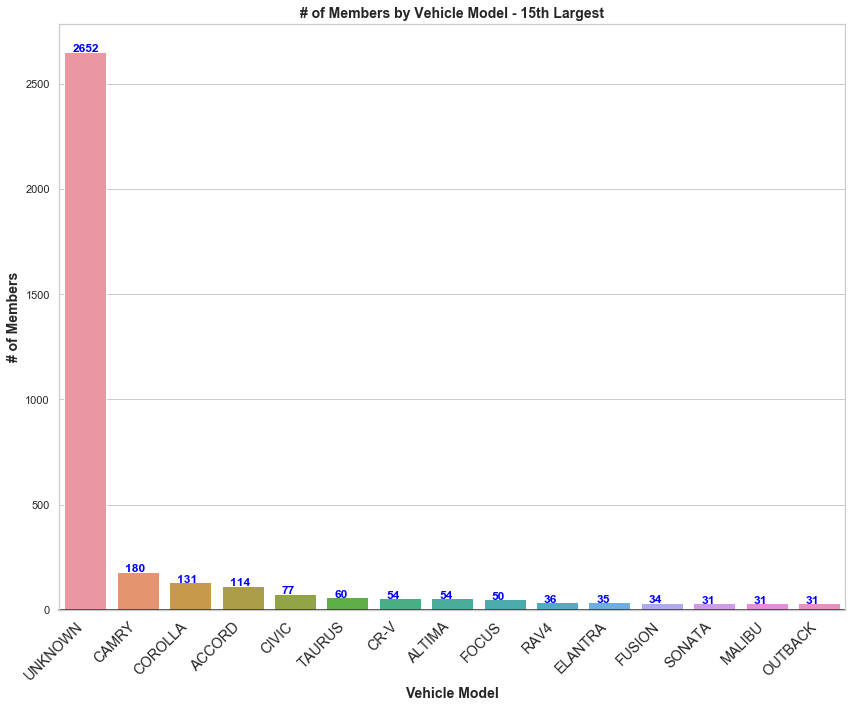

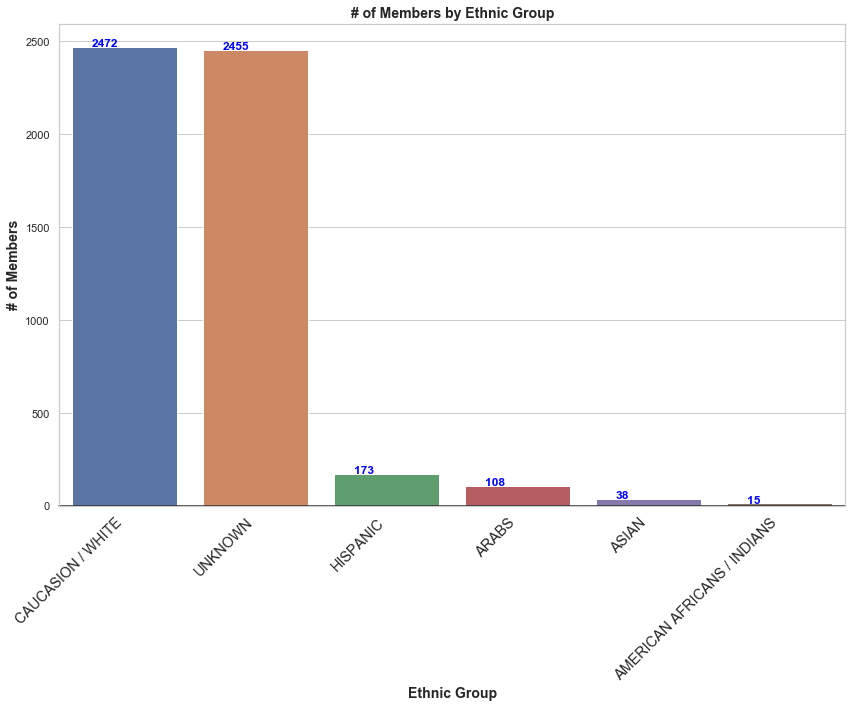

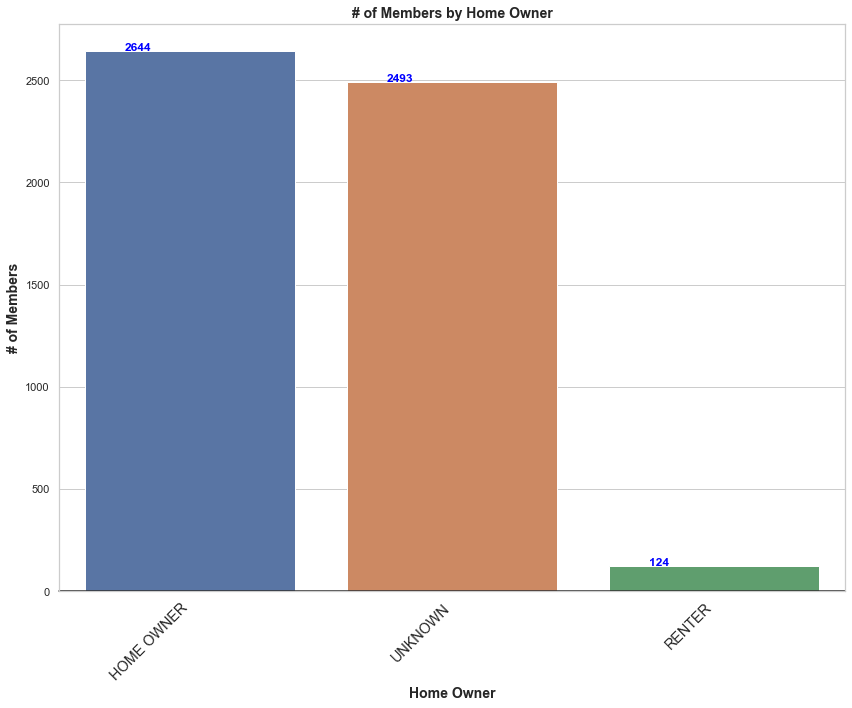

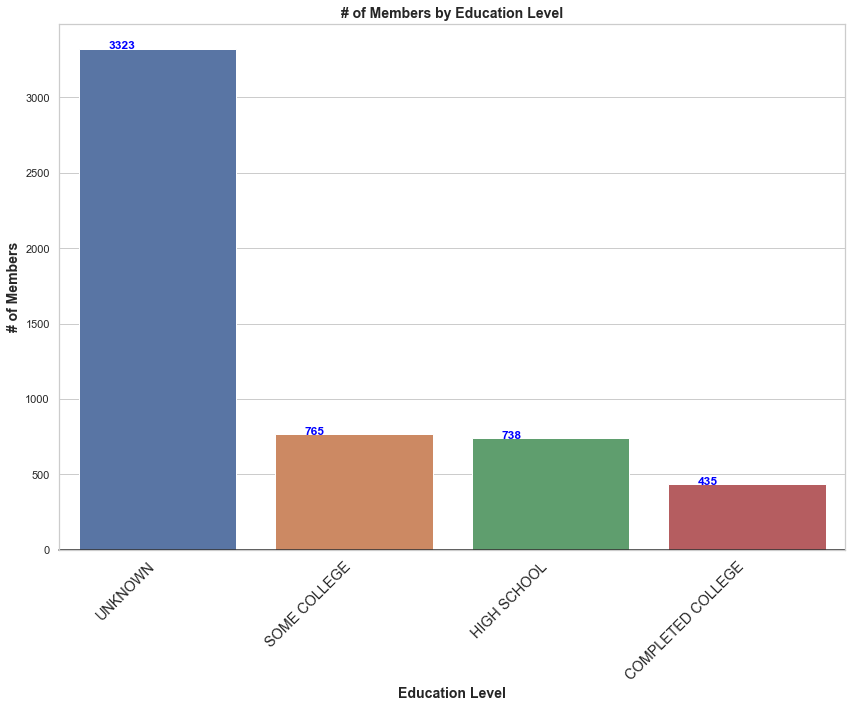

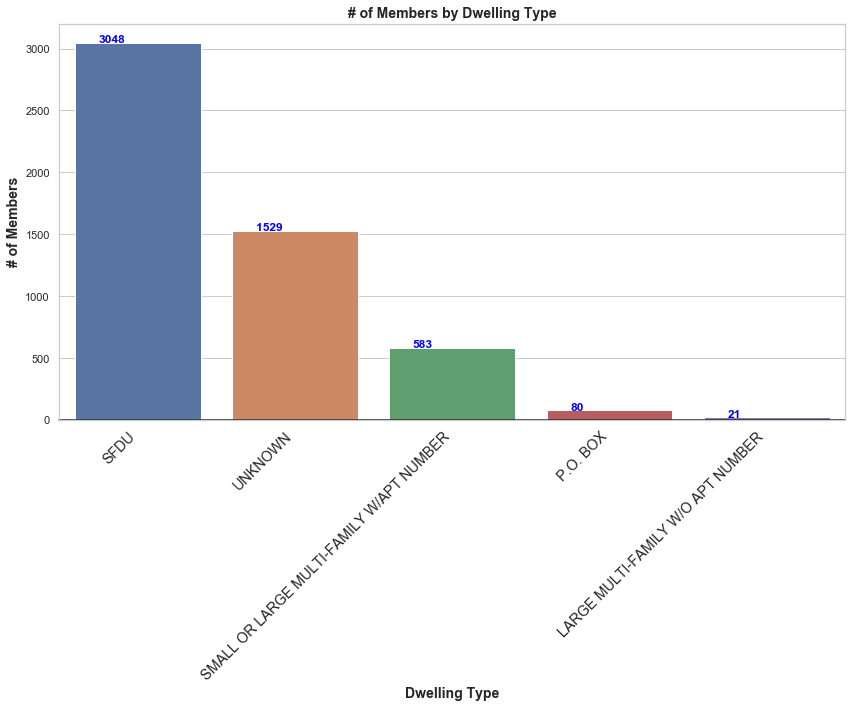

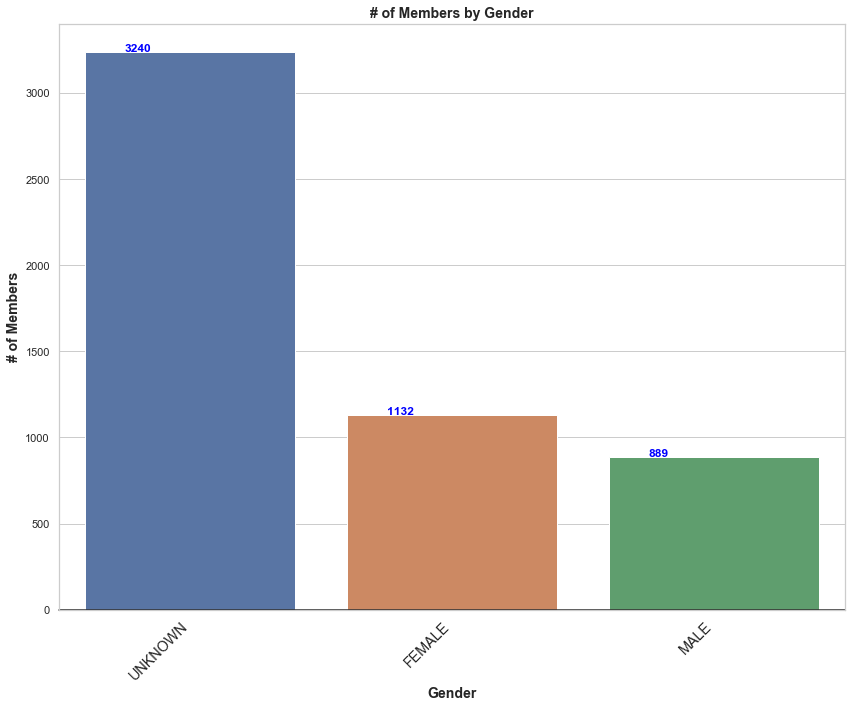

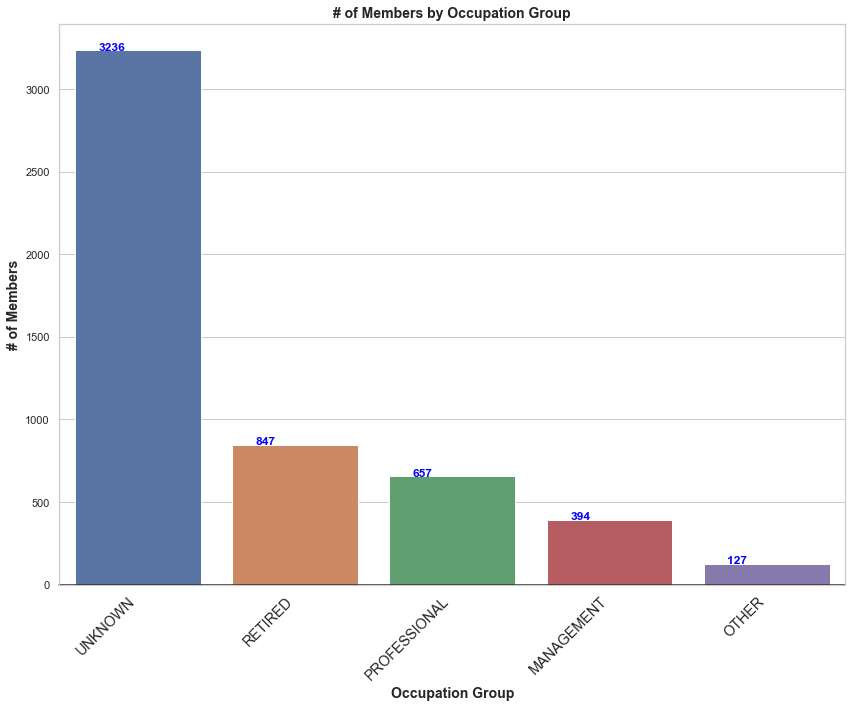

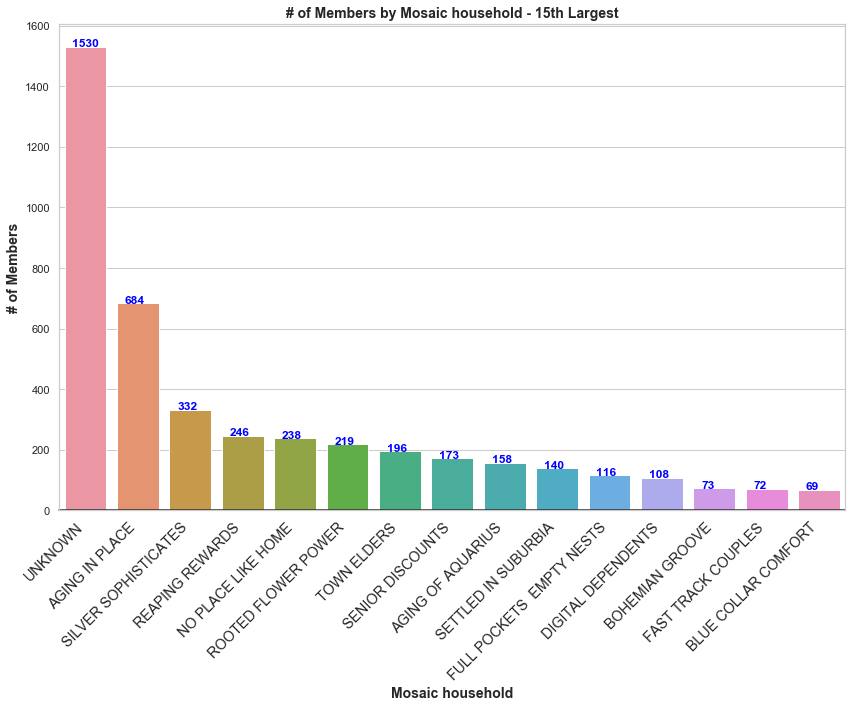

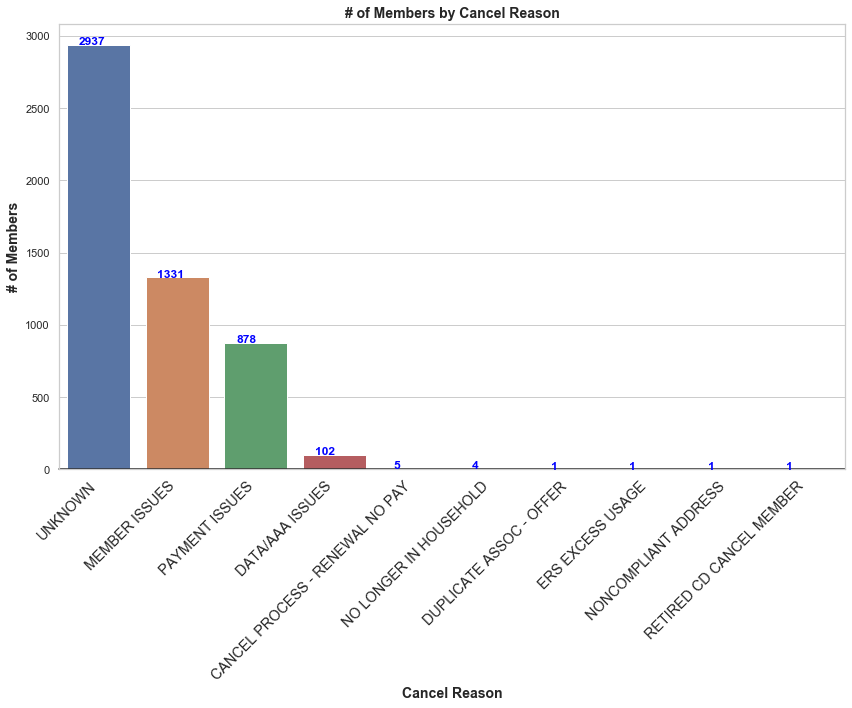

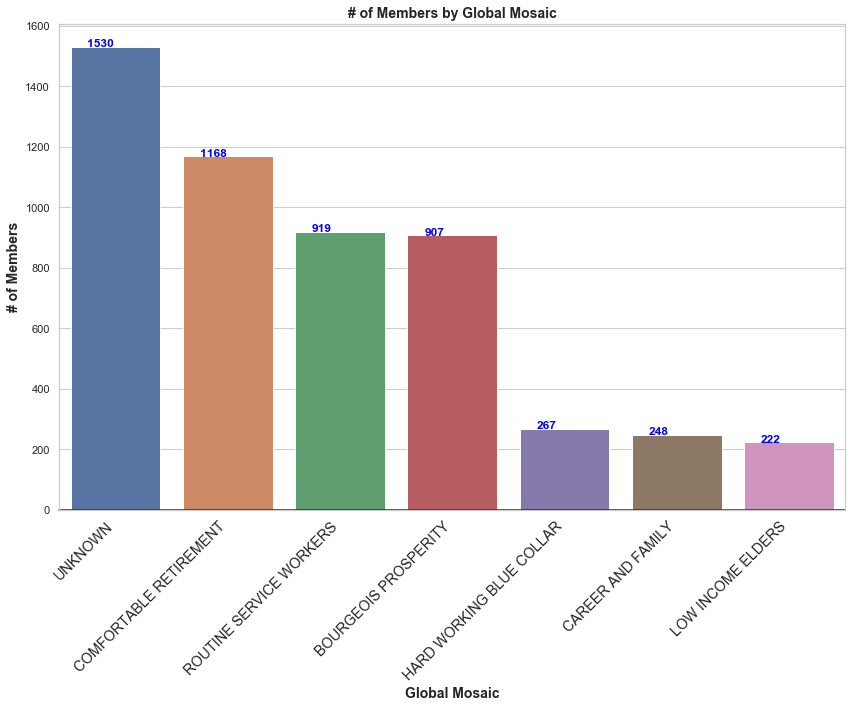

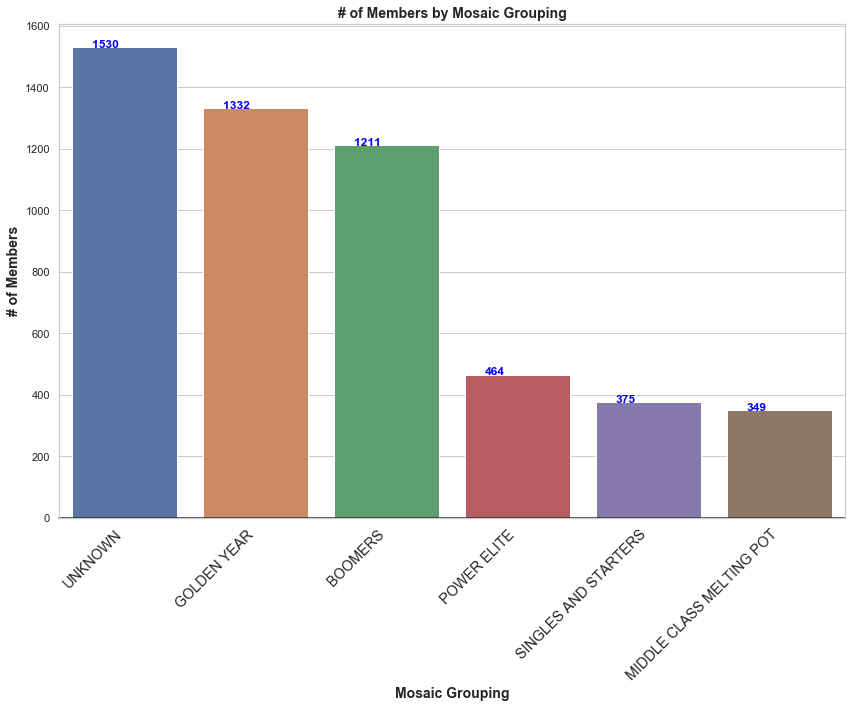

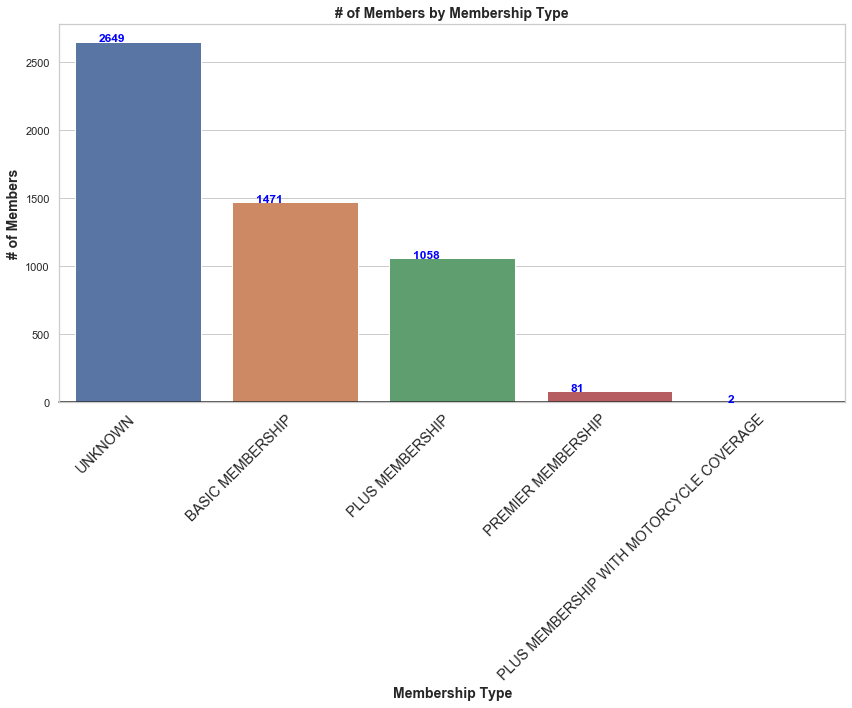

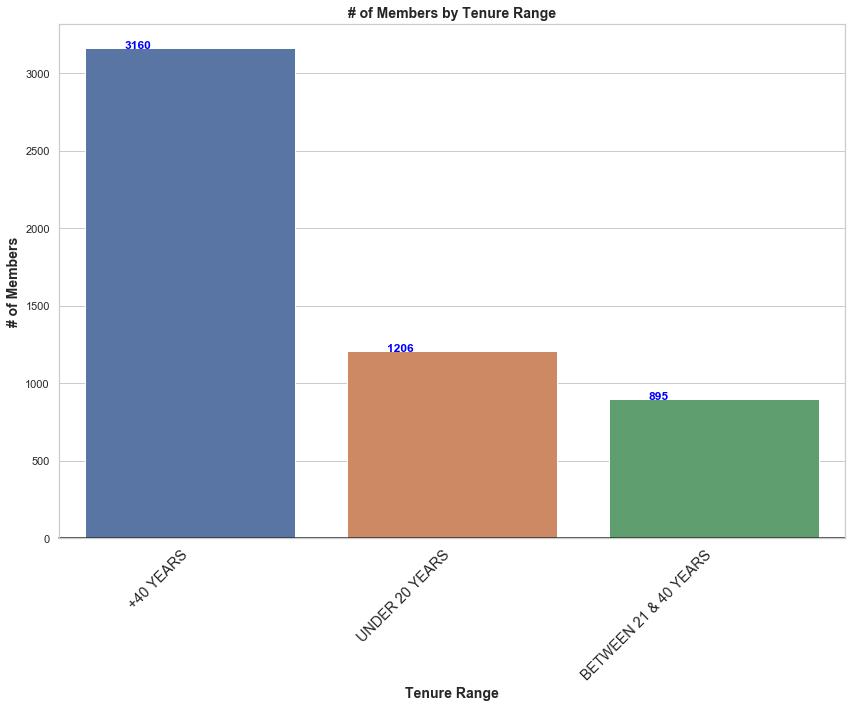

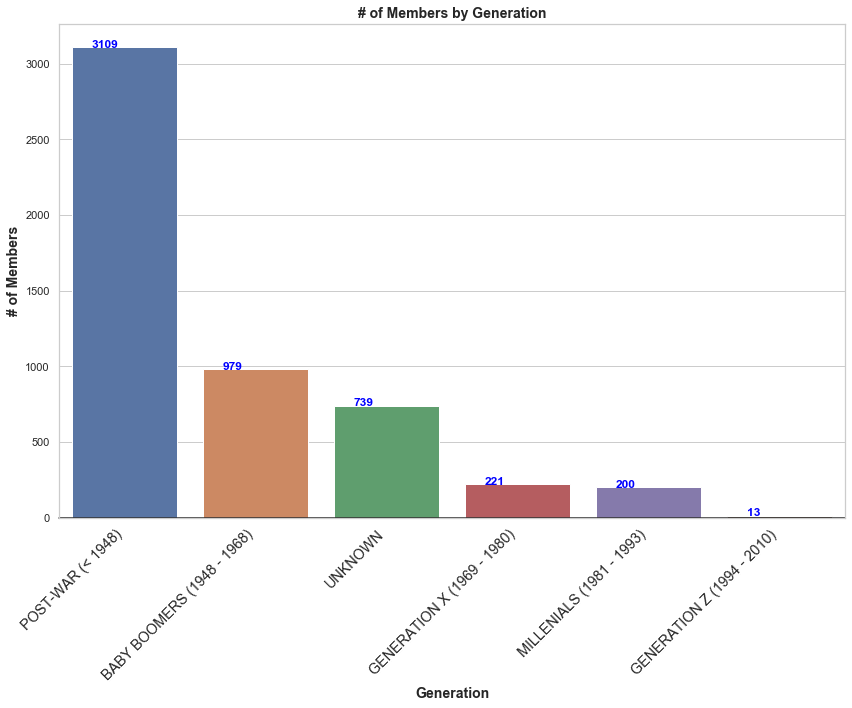

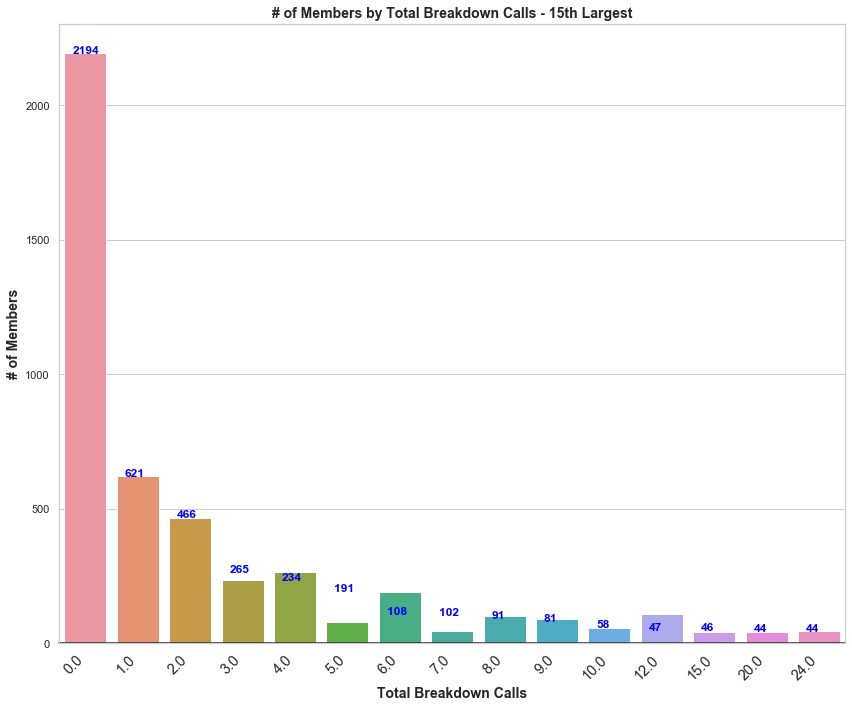

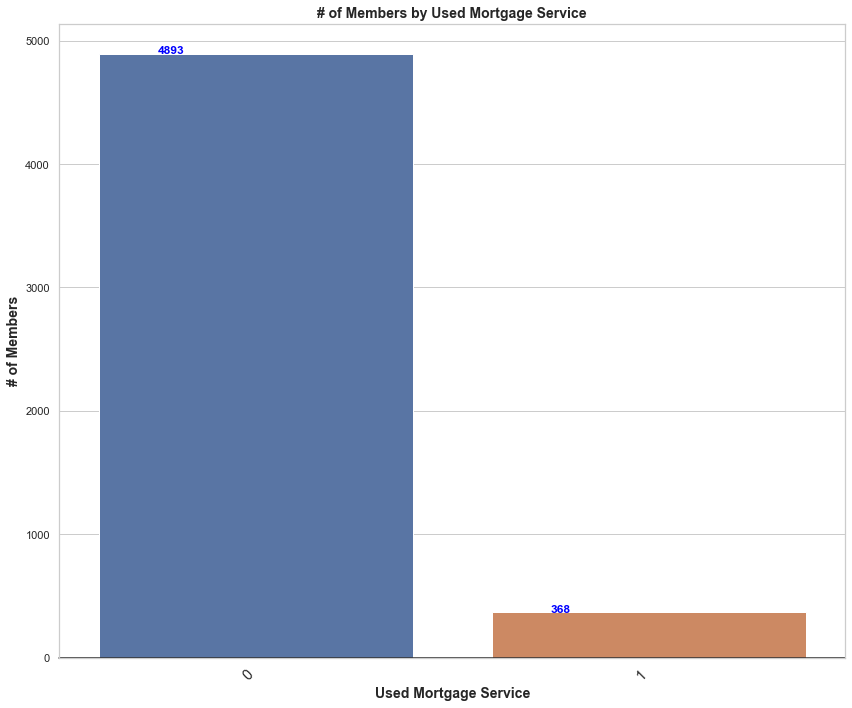

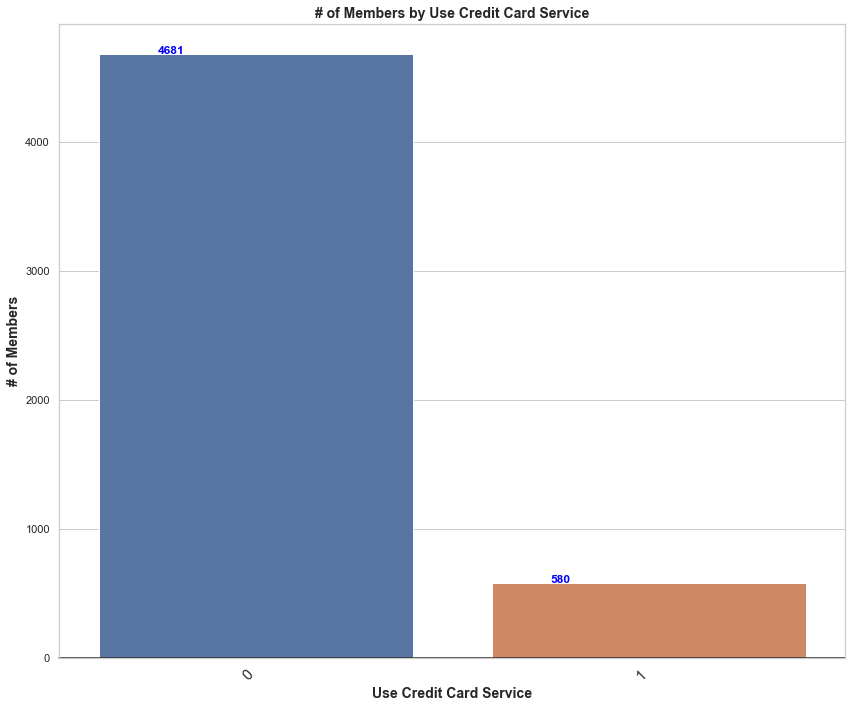

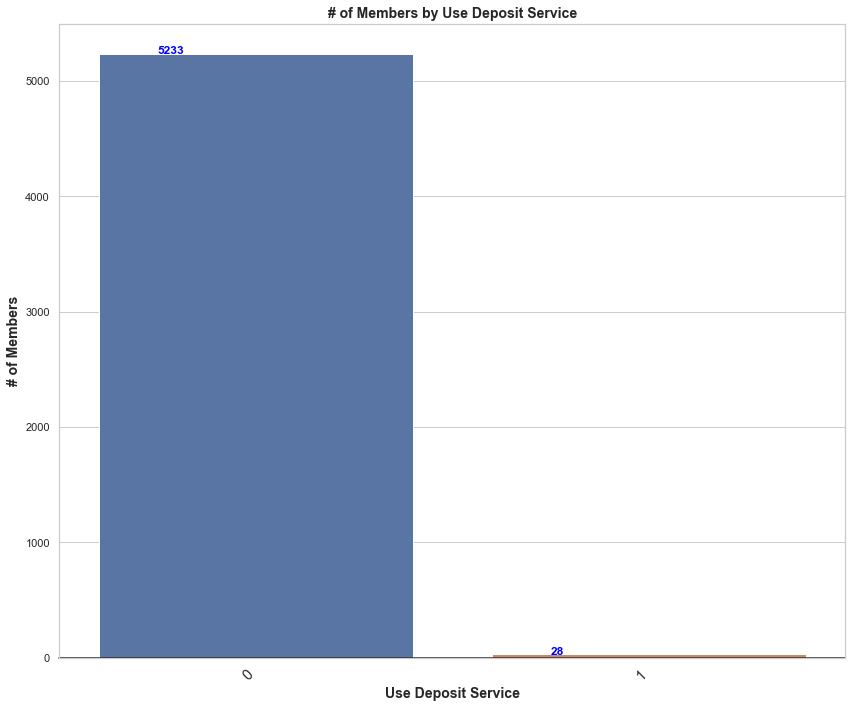

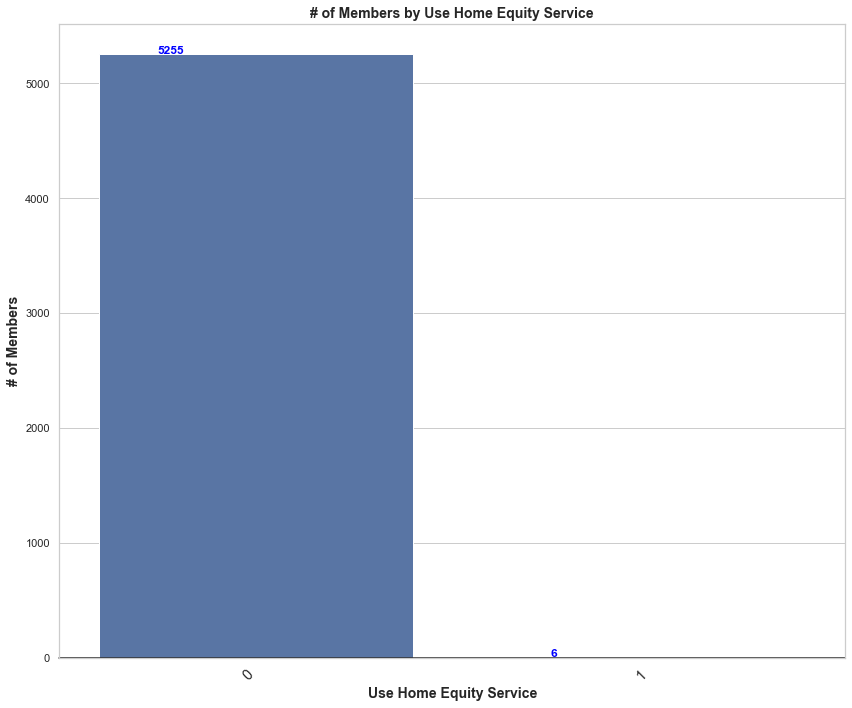

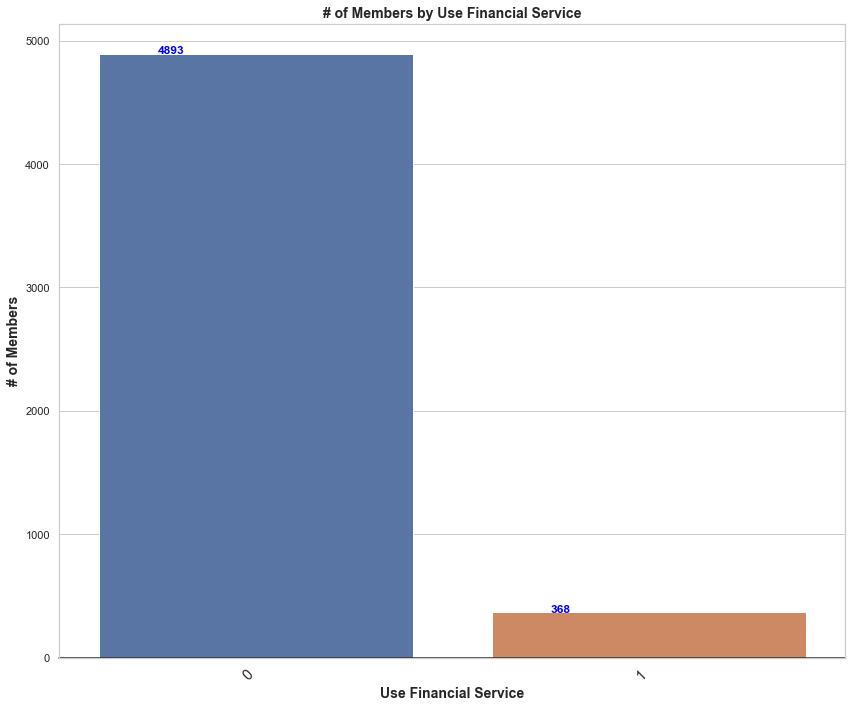

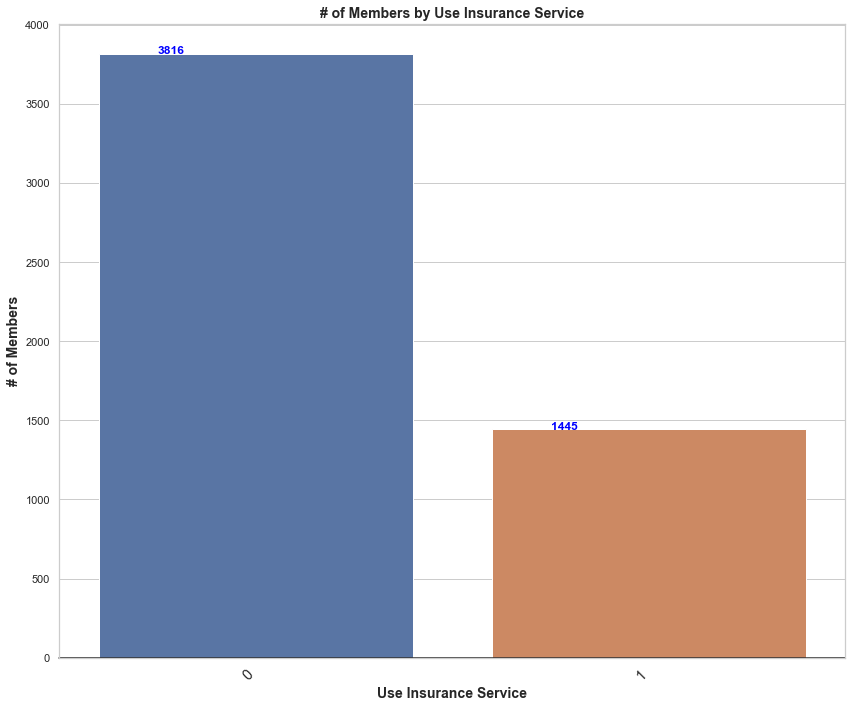

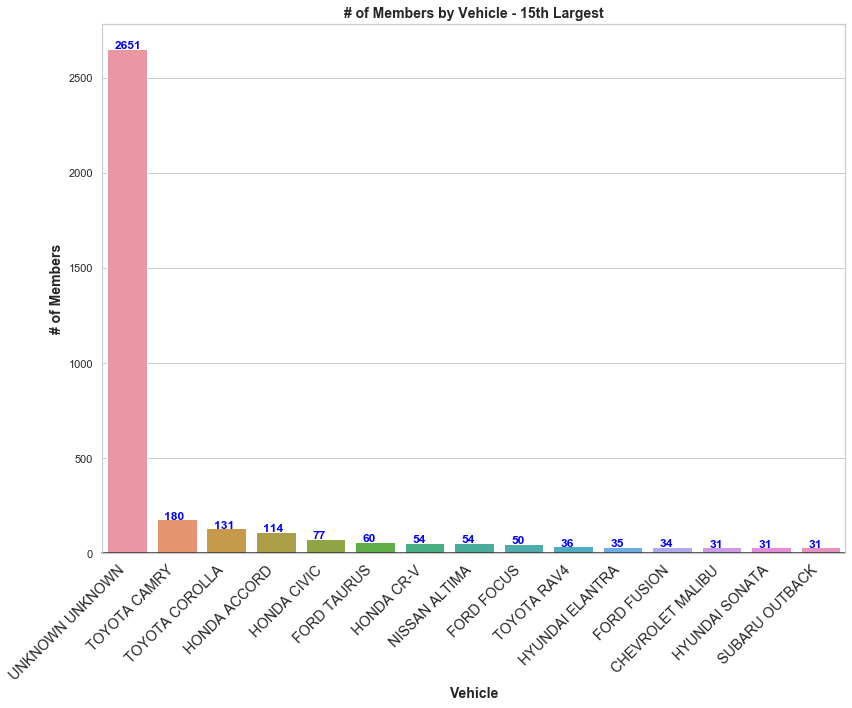

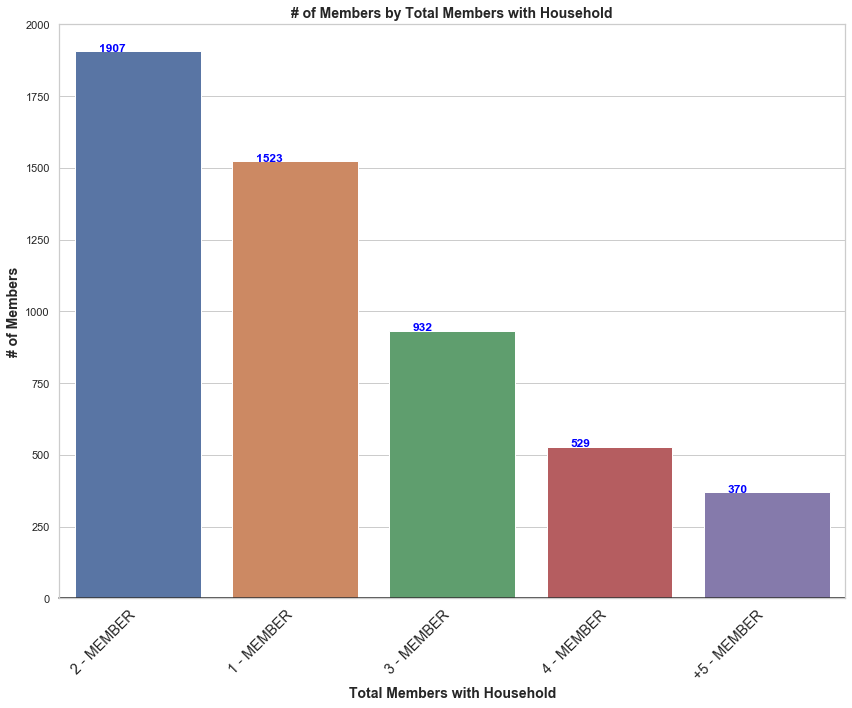

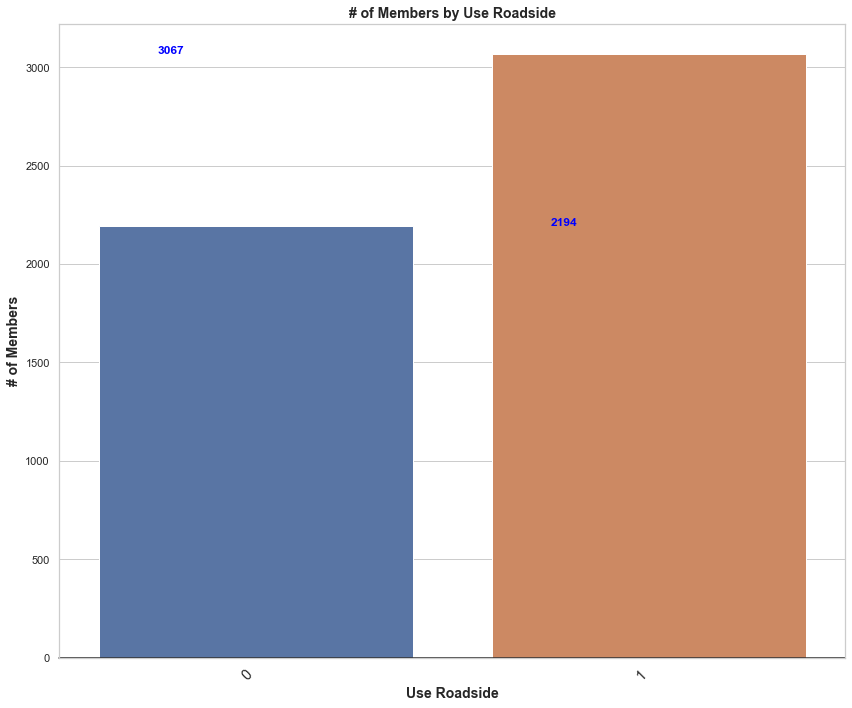

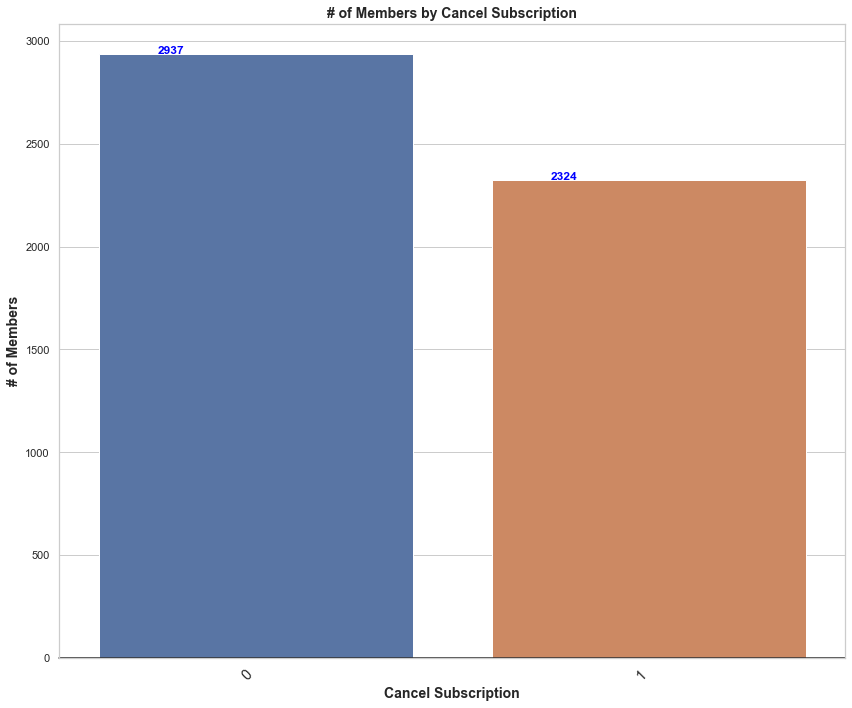

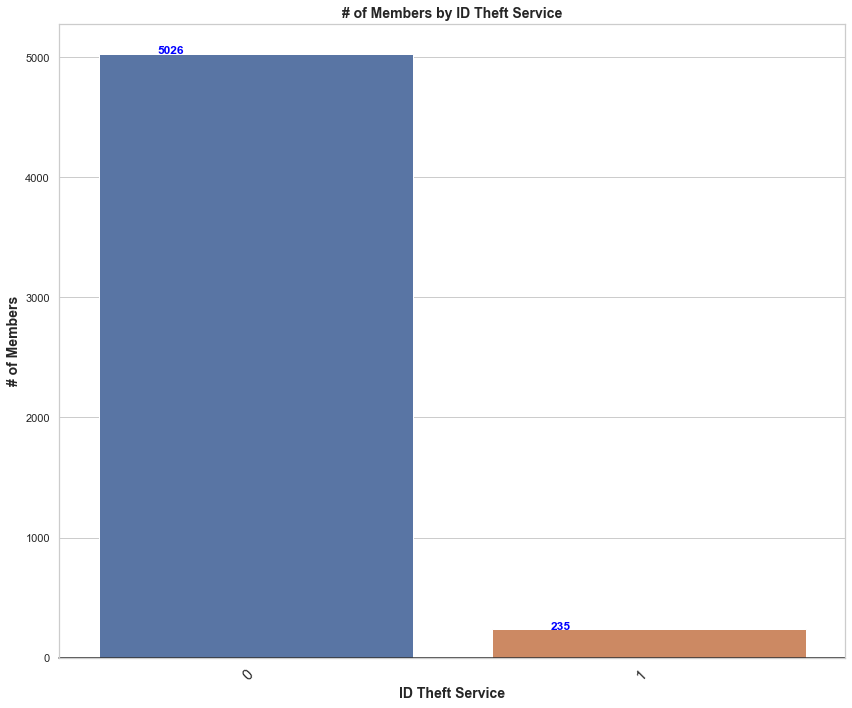

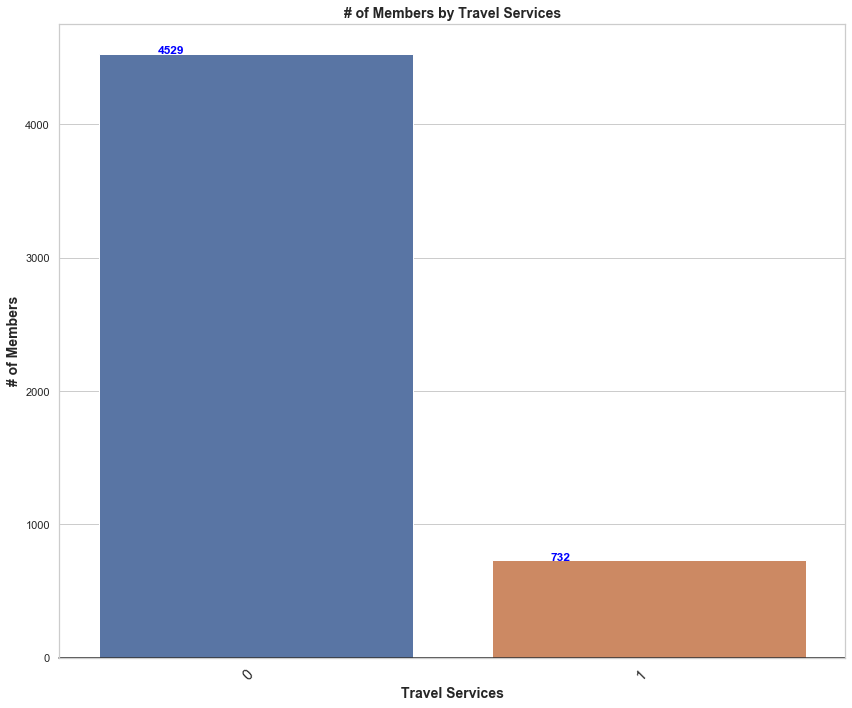

In [65]:
# Columns to plot 
# Not used : 'cancel_reason', 'state_grouped', 'renew_method'
# Not used :'occupation_code', 'occupant_type' - too many unknowns, 

cols = [ 'income', 'credit_ranges', 'member_status', 'sc_vehicle_manufacturer_name','sc_vehicle_model_name','race','home_owner','education', 
        'dwelling_type', 'gender','occupation_group', 'mosaic_household','cancel_reason',
        'mosaic_global_household','kcl_b_ind_mosaicsgrouping', 'plus_indicator_description',
        'tenure', 'generation', 'total_calls', 'aaa_mortgage', 'aaa_credit_card', 
        'aaa_deposit', 'aaa_home_equity', 'aaa_financial_service', 'aaa_auto_insurance', 'vehicle', 
        'no_members', 'use_road_side', 'aaa_cancel', 'aaa_id_theft', 'aaa_travel'
       ]

# Dictionary for X Axis Labels
dict_cols = { 'income':'Income', 'member_status':'Member Status','state_grouped': 'State', 'credit_ranges':'Credit Range',
             'cancel_reason':'Cancel Reason','renew_method':'Renewal Method','sc_vehicle_manufacturer_name':'Vehicle Manufacturer',
             'sc_vehicle_model_name':'Vehicle Model','race': 'Ethnic Group','home_owner': 'Home Owner','education':'Education Level', 
             'dwelling_type': 'Dwelling Type', 'gender':'Gender','occupation_code':'Occupation', 'occupation_group':'Occupation Group',
             'occupant_type': 'Occupant Type','mosaic_household':'Mosaic household','mosaic_global_household':'Global Mosaic',
             'kcl_b_ind_mosaicsgrouping':'Mosaic Grouping', 'plus_indicator_description':'Membership Type',
             'tenure':'Tenure Range', 'generation':'Generation', 'total_calls':'Total Breakdown Calls', 'aaa_mortgage':'Used Mortgage Service',
             'aaa_credit_card':'Use Credit Card Service','aaa_deposit':'Use Deposit Service','aaa_travel':'Travel Services',
             'aaa_home_equity':'Use Home Equity Service', 'aaa_financial_service':'Use Financial Service', 
             'aaa_auto_insurance':'Use Insurance Service', 'vehicle':'Vehicle','total_member_cost':'Total Member Avg. Costs',
             'no_members':'Total Members with Household', 'aaa_id_theft':'ID Theft Service', 
             'use_road_side':'Use Roadside',  'aaa_cancel' : 'Cancel Subscription', '0' :'No', '1':'Yes',
             'total_tow_miles': 'Total Tow Miles', 'mean_tow_miles': 'Mean total miles', 'consumer_score' : 'Consumer Score'
                }



# number of members per state

for col in cols:
    counts = df_feature[col].value_counts()
    more_15 = False
    if len(counts) > 14:
        counts = df_feature[col].value_counts().nlargest(15)
        more_15 = True
    sns.set(style="whitegrid")
    plt.axhline(0, color="k", clip_on=False)
    plt.ylabel("# of Members",fontsize=14, fontweight='bold')
    plt.xlabel(dict_cols[col], fontsize=14, fontweight='bold')
    if more_15:
        plt.title('# of Members by '+dict_cols[col] + ' - 15th Largest',loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
        image_name='./pics/Members by '+dict_cols[col]+  ' - 15th Largest - Bar Chart.png'
    else:       
        plt.title('# of Members by '+dict_cols[col],loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
        image_name='./pics/Members by '+dict_cols[col]+  ' - Bar Chart.png'
    
    sns.barplot(counts.index, counts.values)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='large')
    i = 0
    for v in list(counts.index):
        #plt.text(i-.25, v, str(v), color='blue', fontweight='bold')
        plt.text(i-.25, counts.values[i], str(counts.values[i]), color='blue', fontweight='bold')
        i +=1
    
    plt.savefig(image_name)
    plt.show()
    if more_15:
        counts = pd.DataFrame(df_feature[col].value_counts().nlargest(15), index=None)
        image_name='./pics/Members by '+dict_cols[col]+  ' - 15th Largest - Table.png'
    else:
        counts = pd.DataFrame(df_feature[col].value_counts(), index=None)
    counts.rename(columns={"index": dict_cols[col], col: "# of Members"}, inplace=True)
    counts.reset_index(inplace=True)
    fig = ff.create_table(counts, height_constant=30, index=False)
    py.iplot(fig)
    fig.write_image(image_name)

# Plot costs of calls to AAA for services - ONLY ACTIVE OR PENDING in member status.

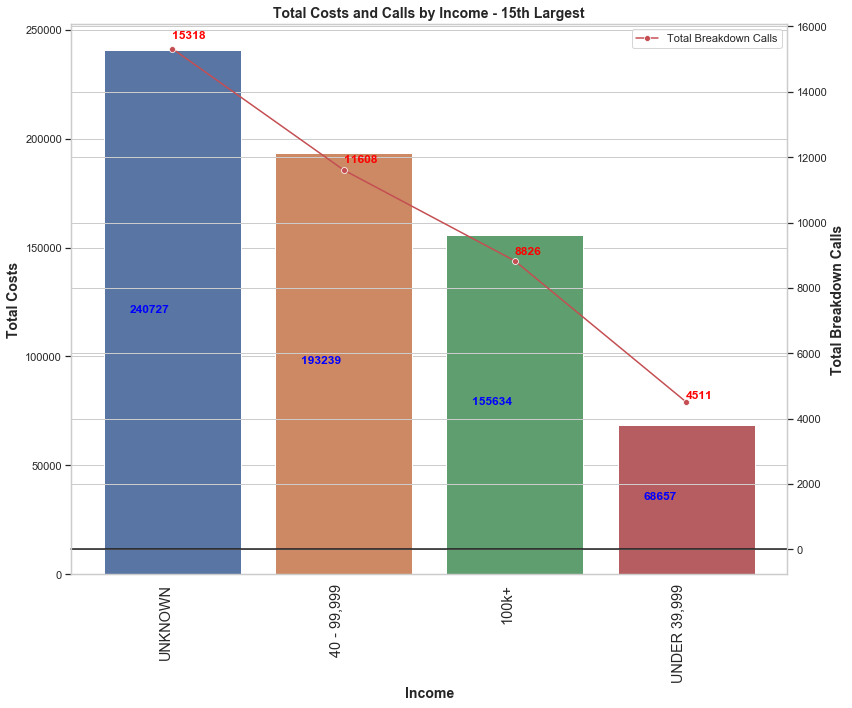

In [67]:
# Columns to plot Total costs and total calls
cols = [ 'income', 'member_status','state_grouped', 'credit_ranges', 'cancel_reason','renew_method',
        'sc_vehicle_manufacturer_name','sc_vehicle_model_name','race','home_owner','education', 
        'dwelling_type', 'gender','occupation_code', 'occupation_group', 'occupant_type','mosaic_household',
        'mosaic_global_household','kcl_b_ind_mosaicsgrouping', 'plus_indicator_description',
        'tenure', 'generation', 'aaa_mortgage', 'aaa_credit_card',
        'aaa_deposit', 'aaa_home_equity', 'aaa_financial_service', 'aaa_auto_insurance', 'vehicle',
        'no_members', 'use_road_side', 'aaa_cancel', 'aaa_id_theft', 'aaa_travel'
       ]

# Dictionary for X Axis Labels
dict_cols = { 'income':'Income', 'member_status':'Member Status','state_grouped': 'State', 'credit_ranges':'Credit Range',
             'cancel_reason':'Cancel Reason','renew_method':'Renewal Method','sc_vehicle_manufacturer_name':'Vehicle Manufacturer',
             'sc_vehicle_model_name':'Vehicle Model','race': 'Ethnic Group','home_owner': 'Home Owner','education':'Education Level', 
             'dwelling_type': 'Dwelling Type', 'gender':'Gender','occupation_code':'Occupation', 'occupation_group':'Occupation Group',
             'occupant_type': 'Occupant Type','mosaic_household':'Mosaic household','mosaic_global_household':'Global Mosaic',
             'kcl_b_ind_mosaicsgrouping':'Mosaic Grouping', 'plus_indicator_description':'Membership Type','tenure':'tenure Range', 'generation':'Generation', 
             'aaa_mortgage':'Used Mortgage Service', 'aaa_credit_card':'Use Credit Card Service','aaa_deposit':'Use Deposit Service',
             'aaa_home_equity':'Use Home Equity Service', 'aaa_financial_service':'Use Financial Service', 
             'aaa_auto_insurance':'Use Insurance Service', 'vehicle':'Vehicle', 'total_cost':'Total Costs',
             'total_calls':'Total Breakdown Calls', 'total_member_cost':'Total Member Avg. Costs',
             'no_members':'Total Members with Household', 'aaa_id_theft':'ID Theft Service', 
             'use_road_side':'Use Roadside',  'aaa_cancel' : 'Cancel Subscription', '0' :'No', '1':'Yes',
            }

cols2 = 'total_cost'
cols3 = 'total_calls'

for col in cols:
    
    df_cols = [col, cols2, cols3]
    df = pd.DataFrame(data=df_feature,columns=df_cols)
    df[cols2] = df[cols2].apply(lambda x: int(x))
    df[cols3] = df[cols3].apply(lambda x: int(x))
    df = df.groupby(by=col, axis=0, level=None, as_index=False, 
                    sort=True, group_keys=True, 
                    squeeze=True,observed=False,).sum().nlargest(15,cols2)
    df.sort_values(by=cols2, ascending=False,inplace=True)
    
    fig, ax1 = plt.subplots()
    sns.set(style="whitegrid")
    ax2 = ax1.twinx()
    sns.barplot(df[col], df[cols2], ax=ax1)
    # Show values at the bottom of each bar graph
    i = 0
    for v in list(df[cols2]):
        ax1.text(i-.25, v/2, str(int(v)), color='blue', fontweight='bold')
        i +=1
    # Draw a line plot using a second axis
    sns.lineplot(x=df[col],y=df[cols3], color="r", marker="o", ax=ax2, sort=False)
    i = 0
    for v in list(df[cols3]):
        ax2.text(i, v/0.98, str(int(v)), color='red', fontweight='bold')
        i +=1
    
    ax1.set_ylabel(dict_cols[cols2],fontsize=14, fontweight='bold')
    ax1.set_xlabel(dict_cols[col],fontsize=14, fontweight='bold')
    ax1.set_xticklabels(df[col],rotation=90, horizontalalignment='right', fontweight='light', fontsize='large')
    
    ax2.set_ylabel(dict_cols[cols3],fontsize=14, fontweight='bold')
    ax2.legend(labels=[dict_cols[cols3]], loc='upper right')
              
    plt.axhline(0, color="k", clip_on=False)
    plt.title('Total Costs and Calls by '+dict_cols[col] + ' - 15th Largest',loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
    # Save image
    image_name='./pics/Total Costs and Calls by '+ dict_cols[col]+ ' - 15th Largest - Bar Chart.png'
    plt.savefig(image_name)
    plt.show()
    df['Avg. Costs'] = np.round(df[cols2]/df[cols3],2)
    df.rename(columns={col: dict_cols[col], 'total_cost': "Total Costs", 'total_calls':'Total Breakdown Calls'}, inplace=True)
    fig = ff.create_table(df, height_constant=30, index=False)
    py.iplot(fig)
    image_name='./pics/Total Costs and Calls by '+dict_cols[col]+ ' - 15th Largest - Table.png'
    fig.write_image(image_name)
    break

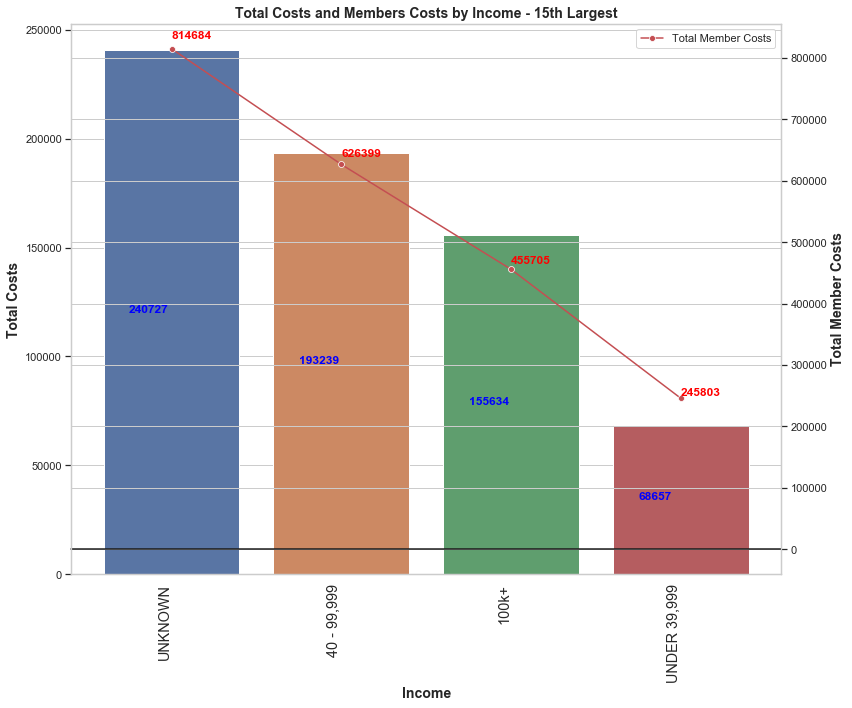

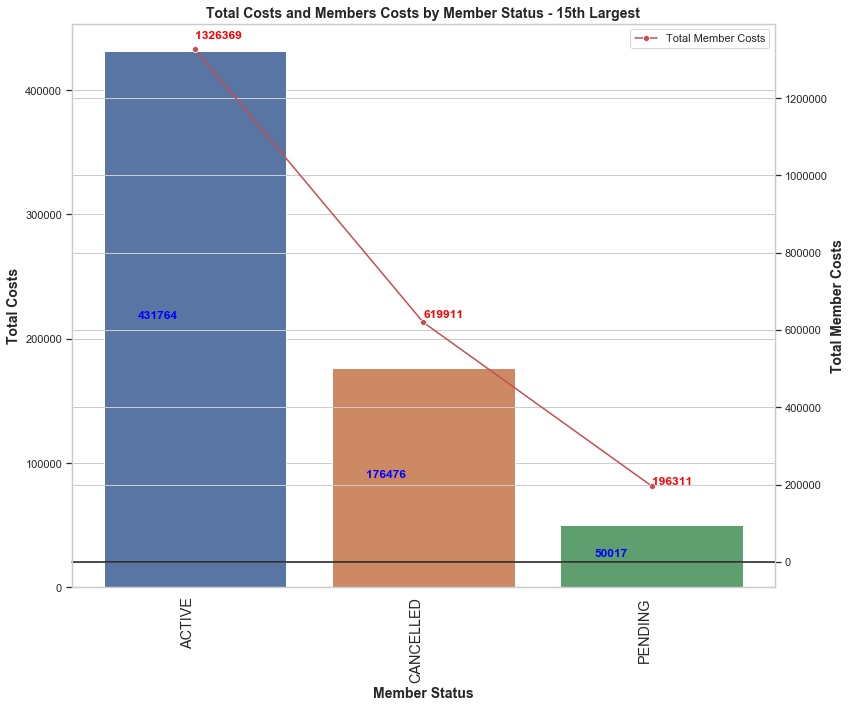

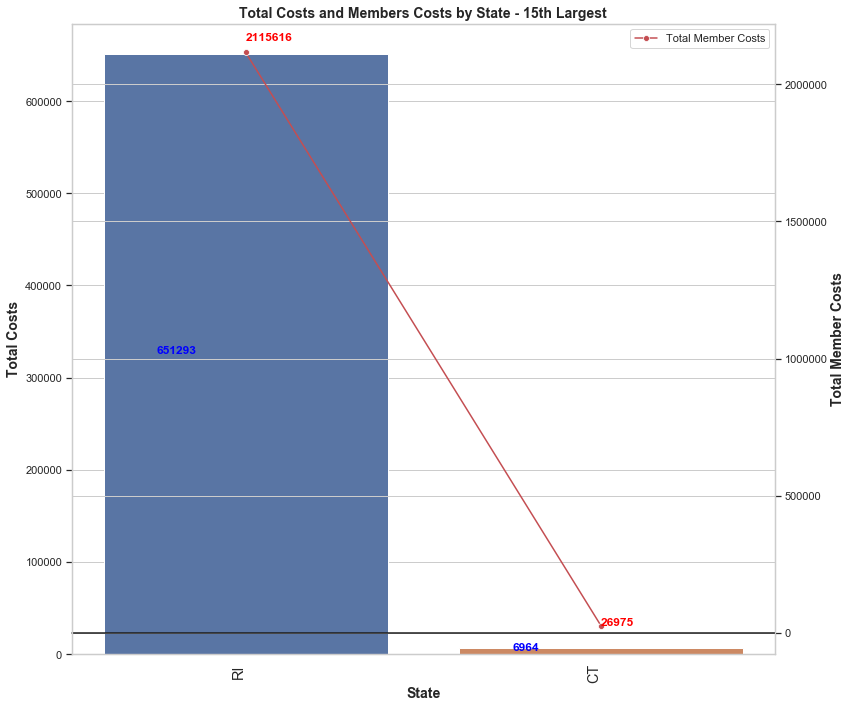

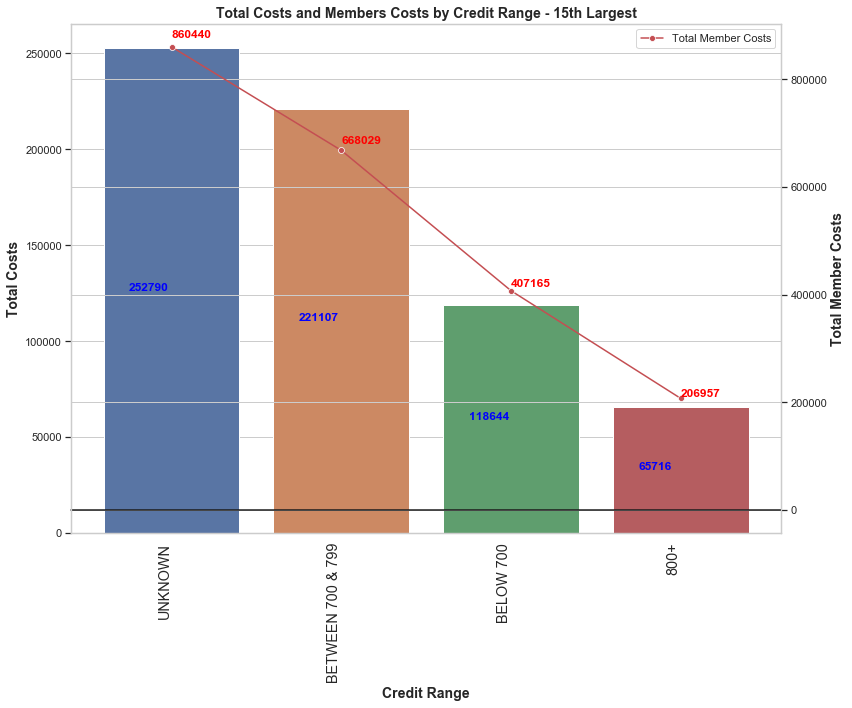

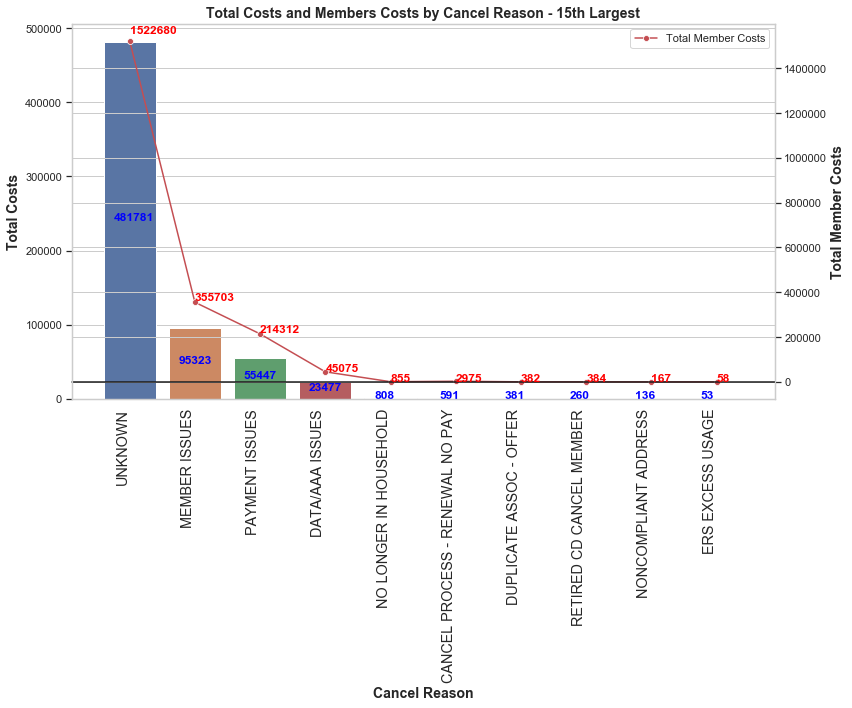

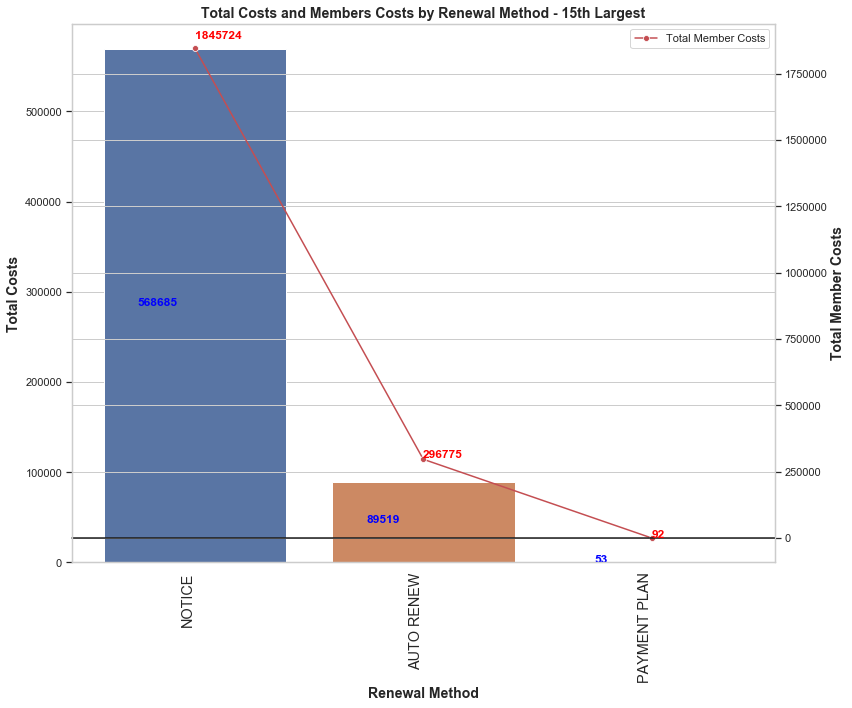

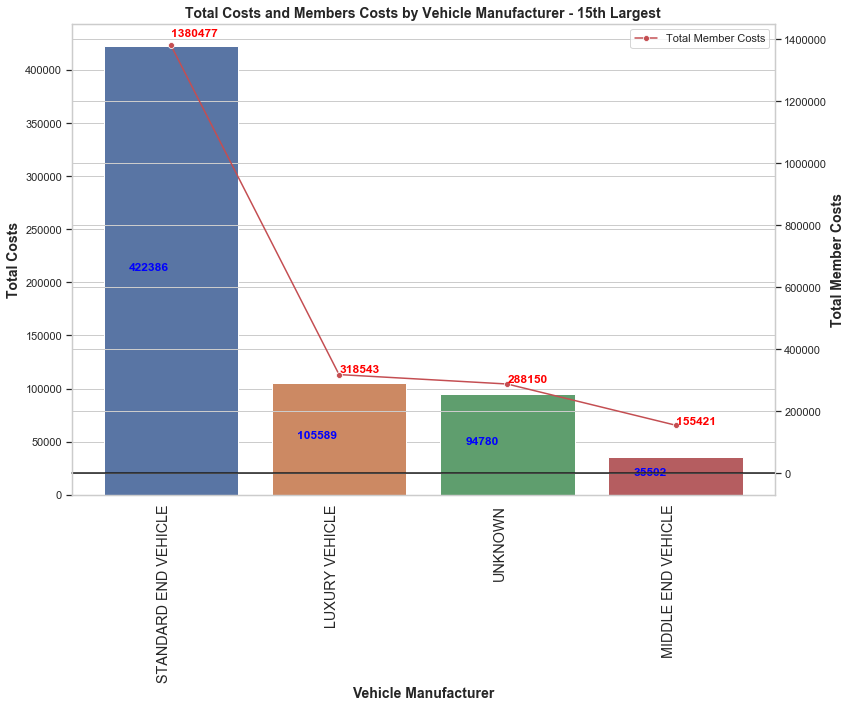

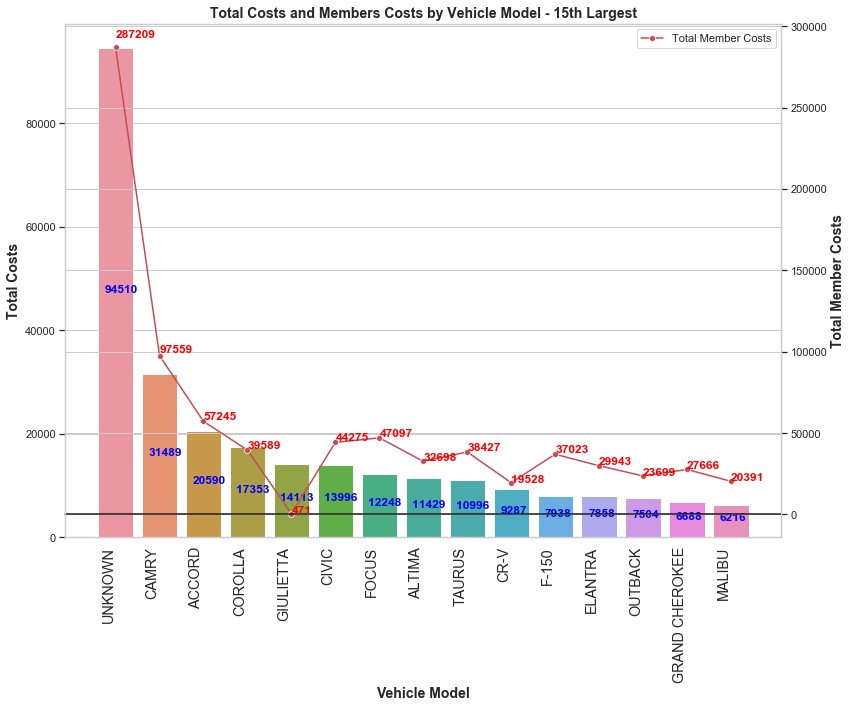

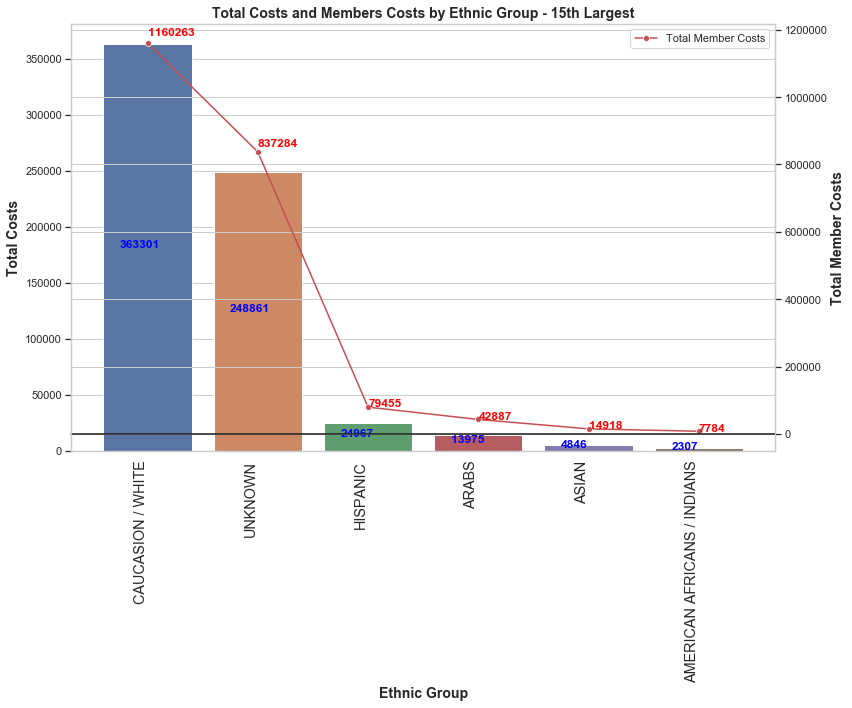

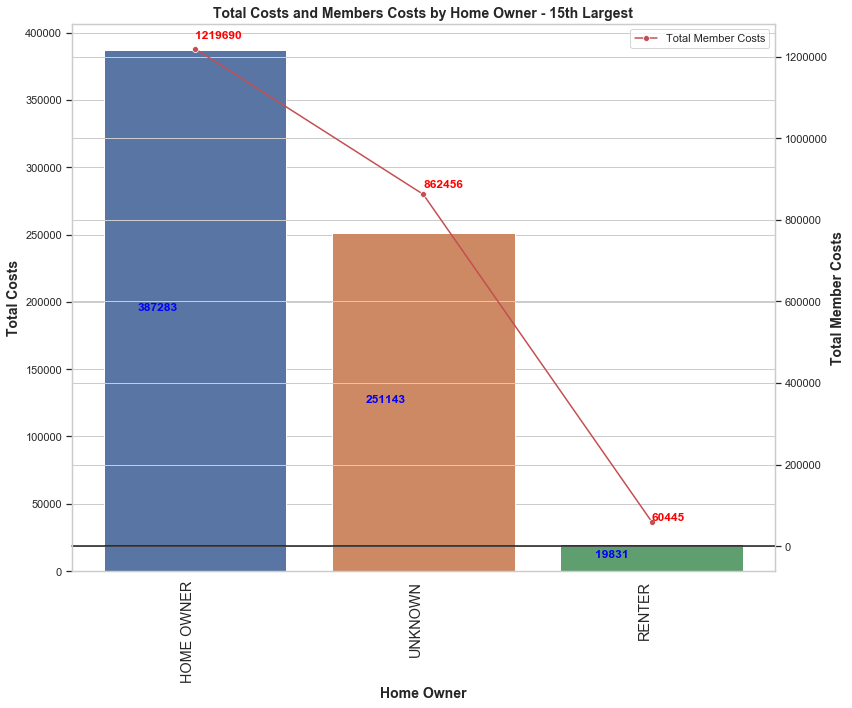

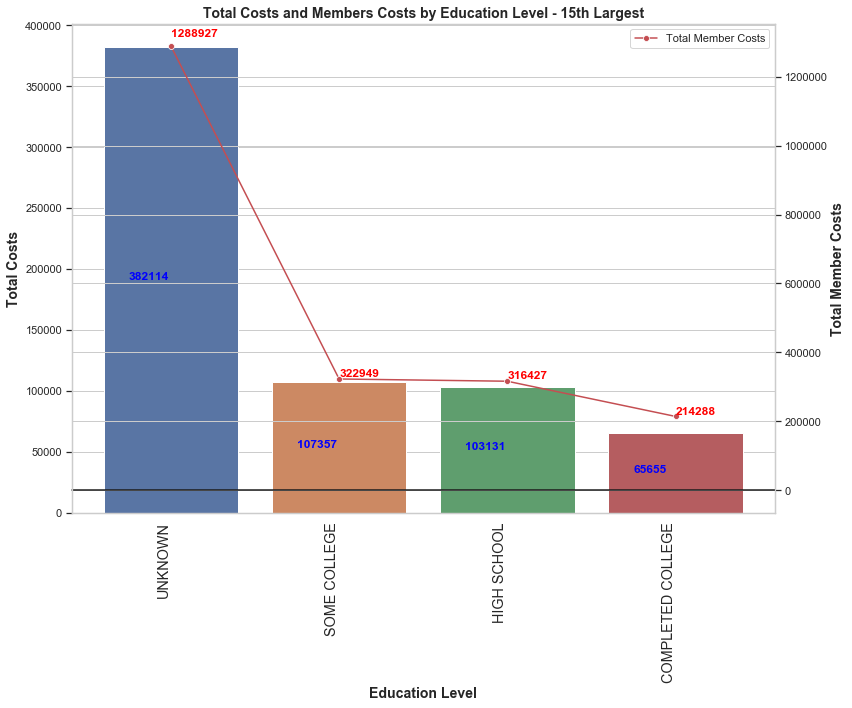

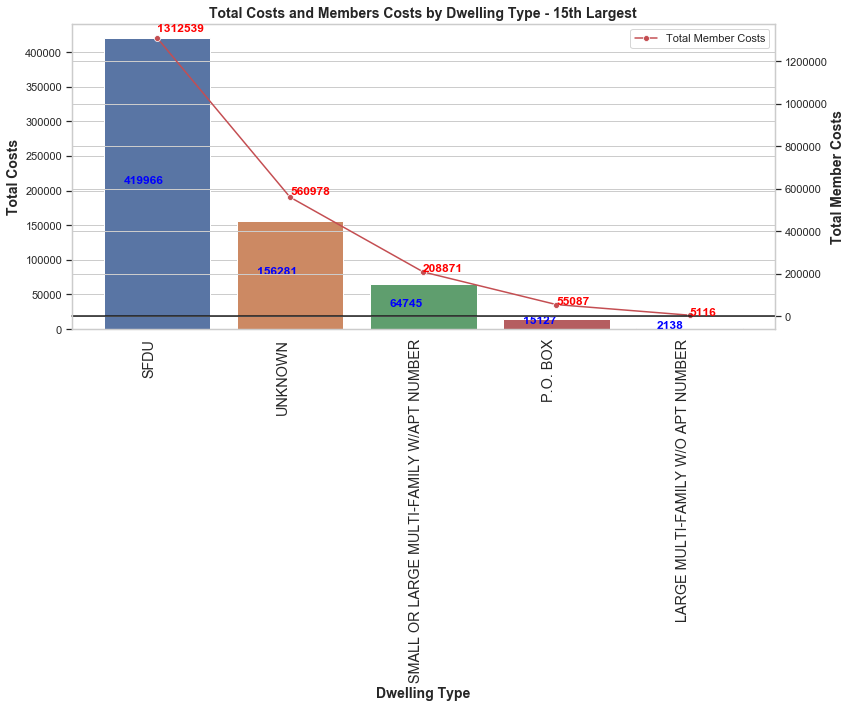

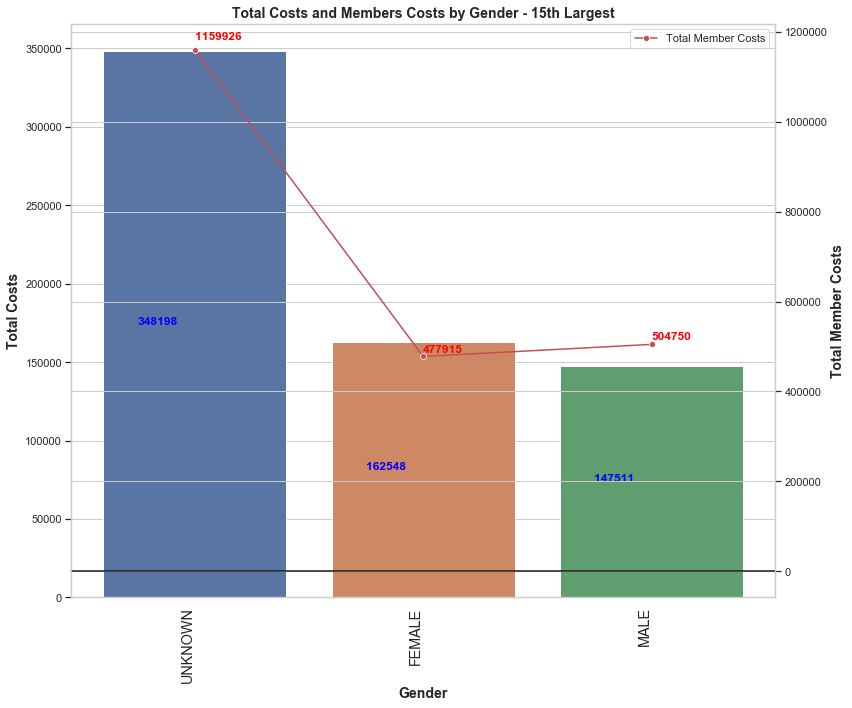

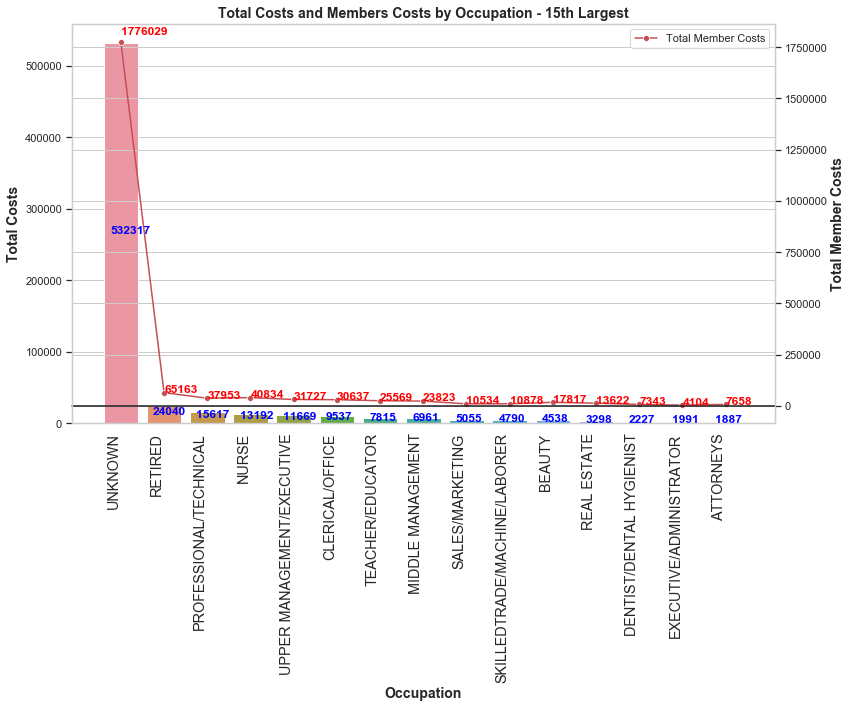

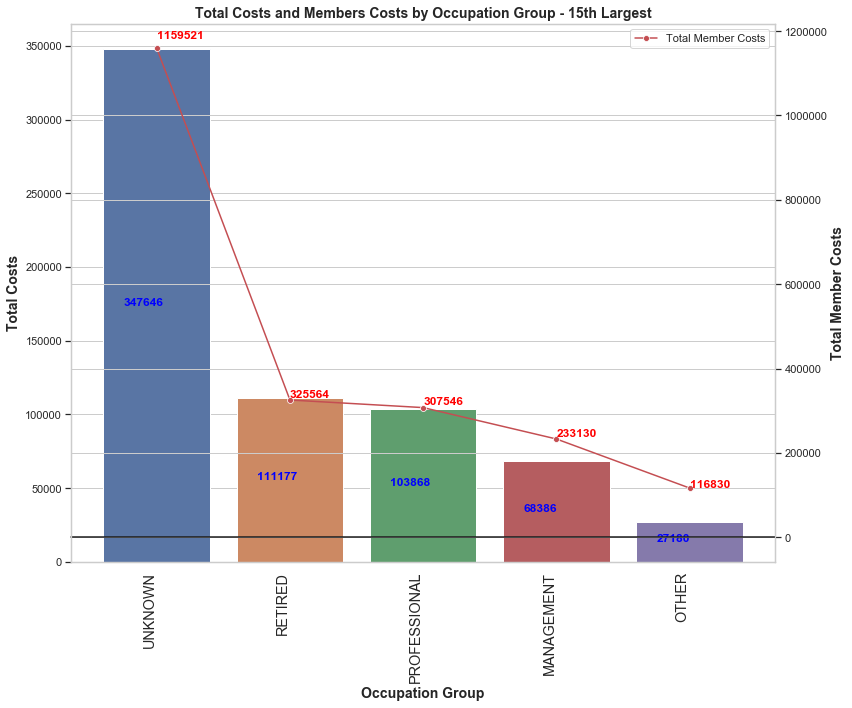

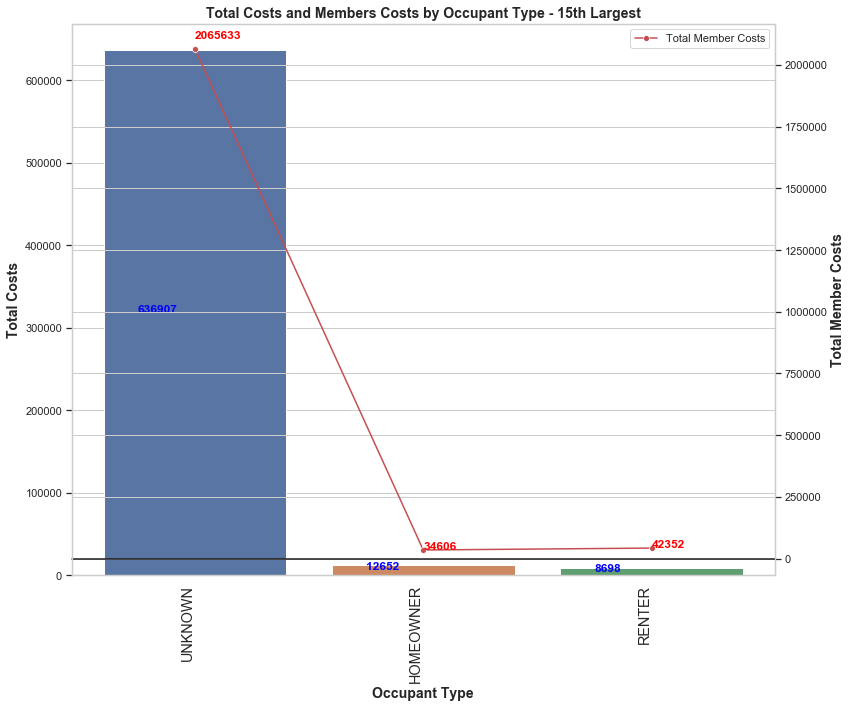

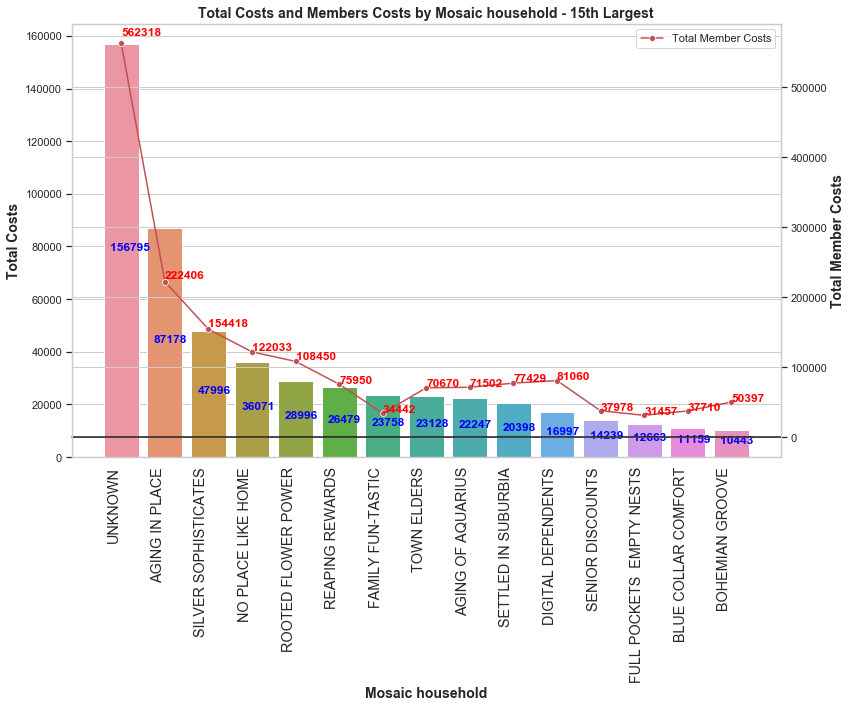

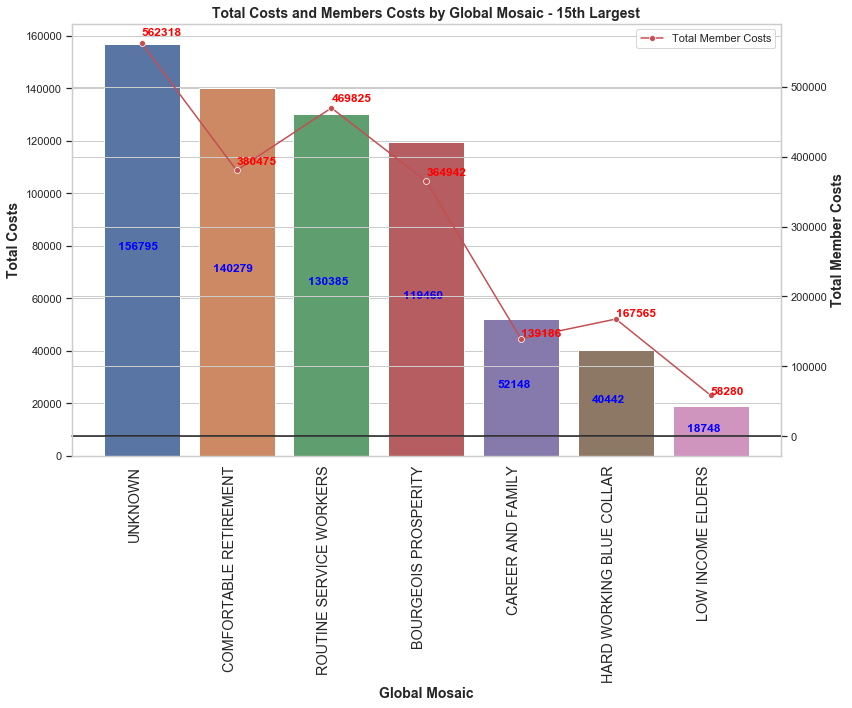

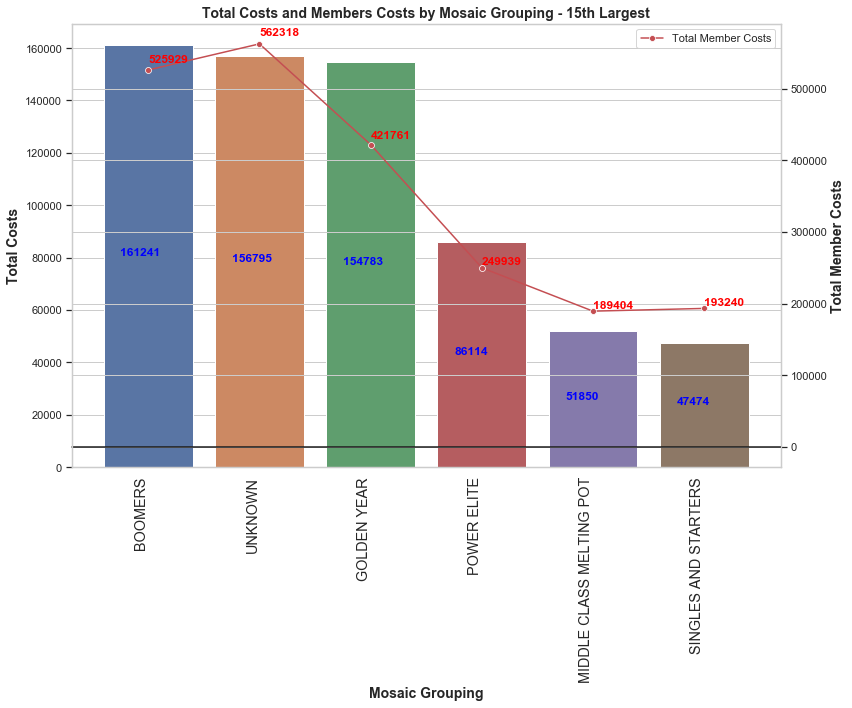

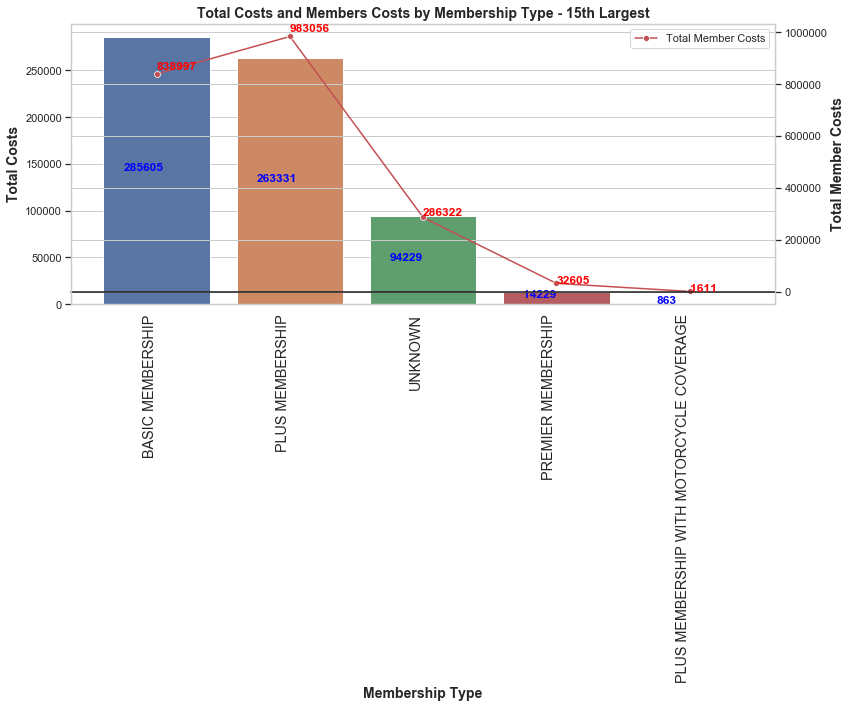

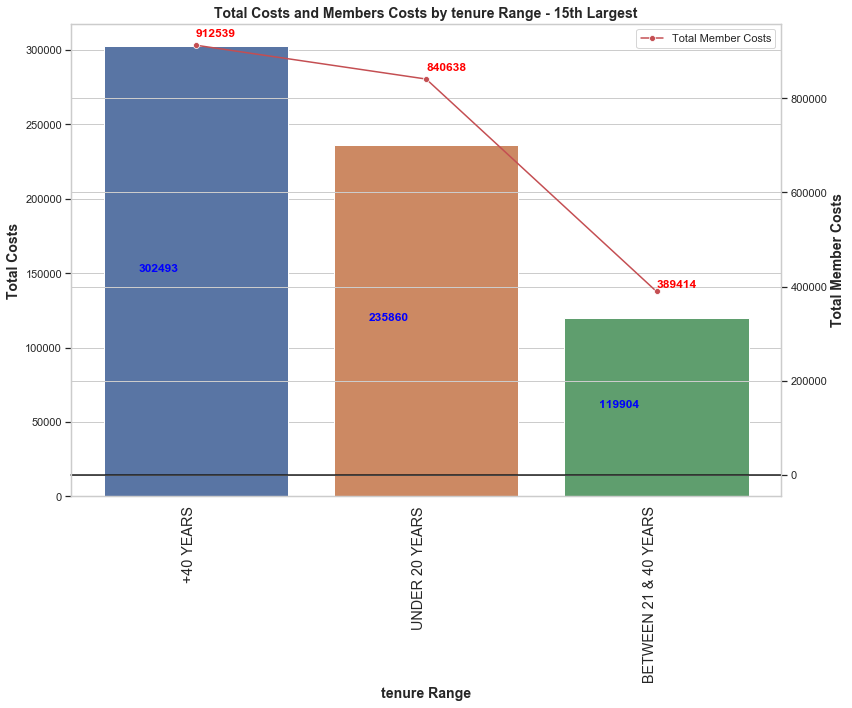

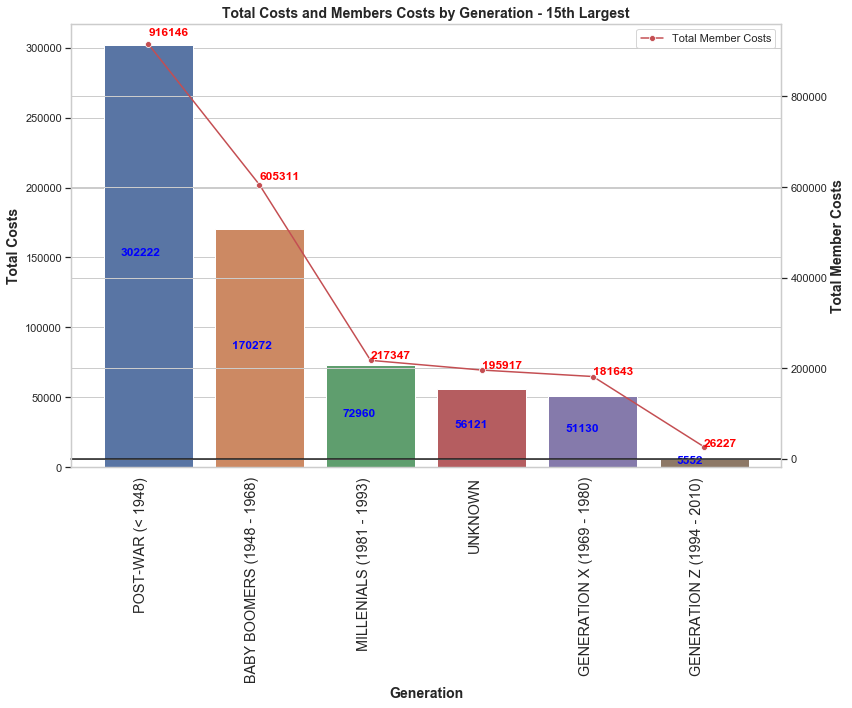

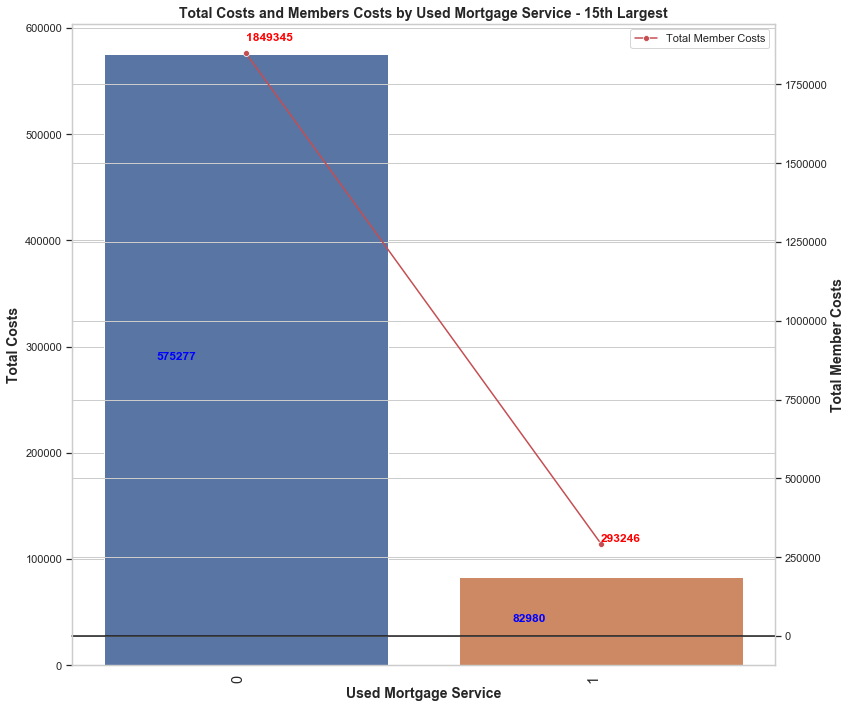

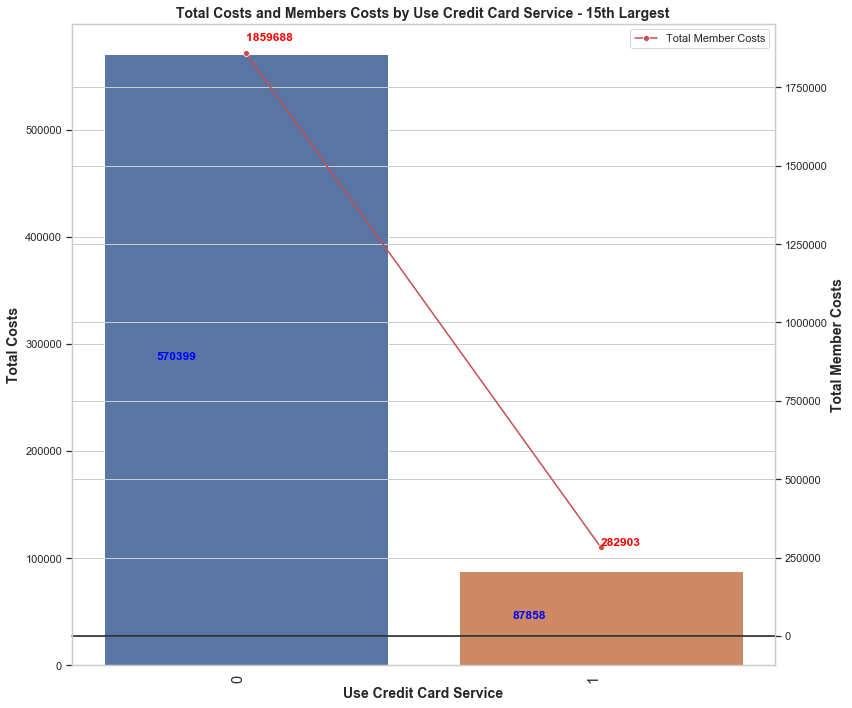

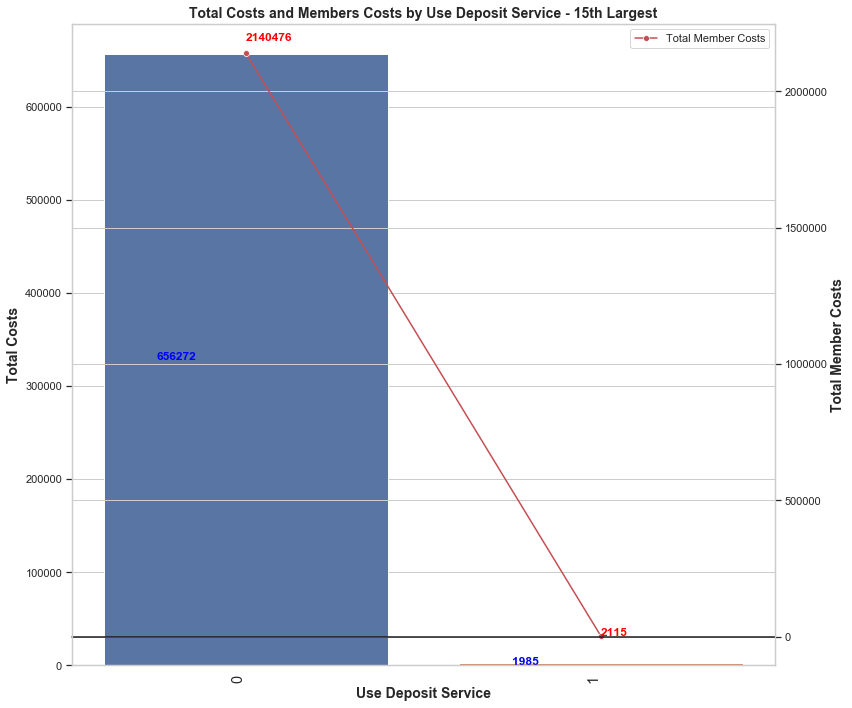

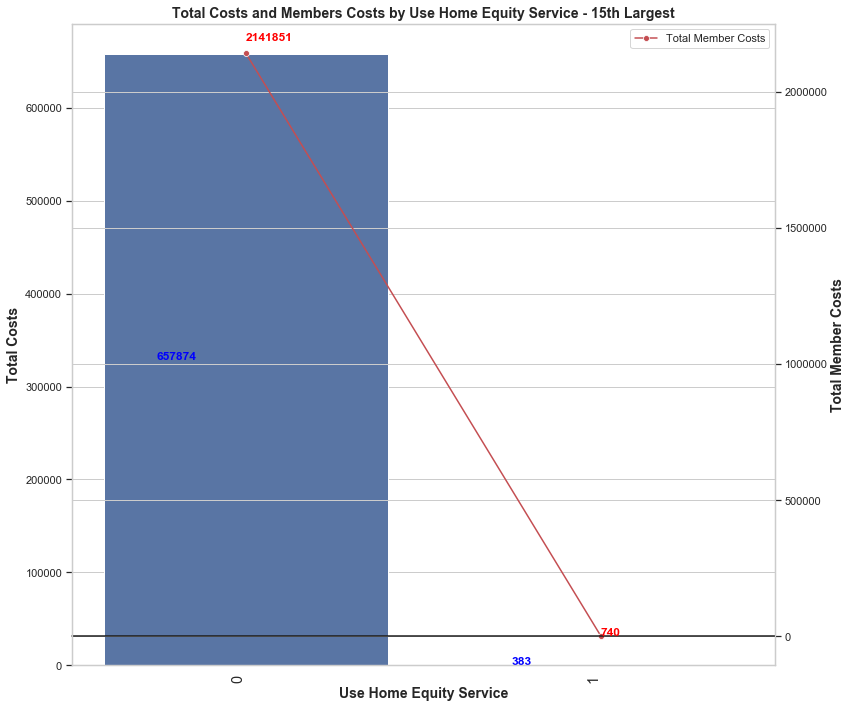

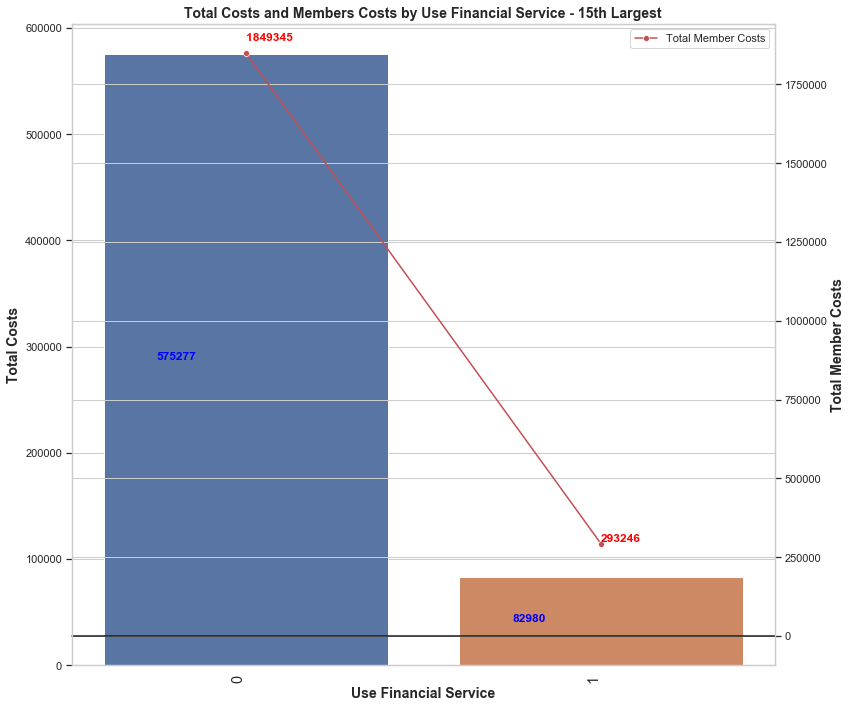

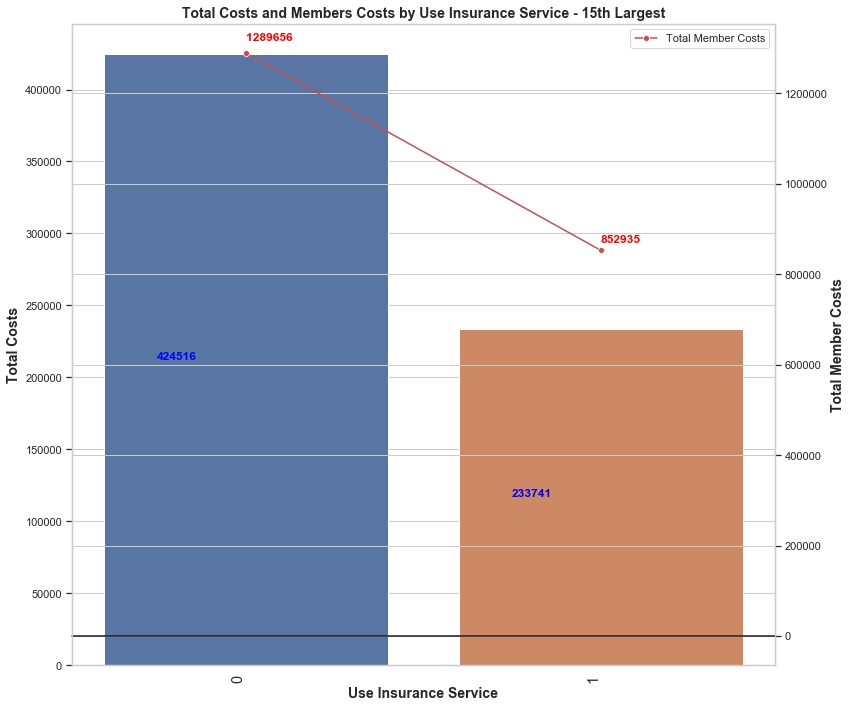

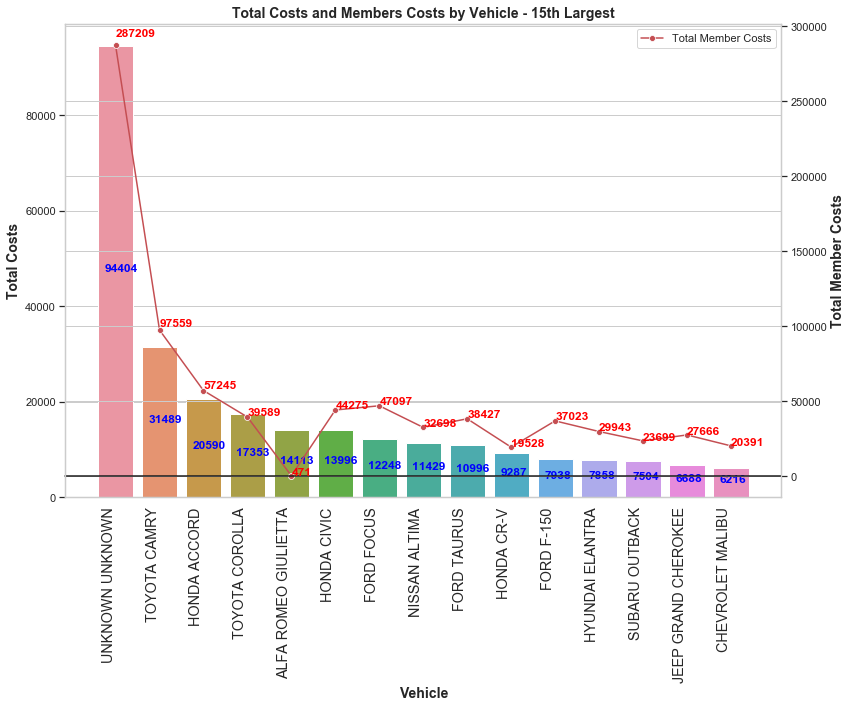

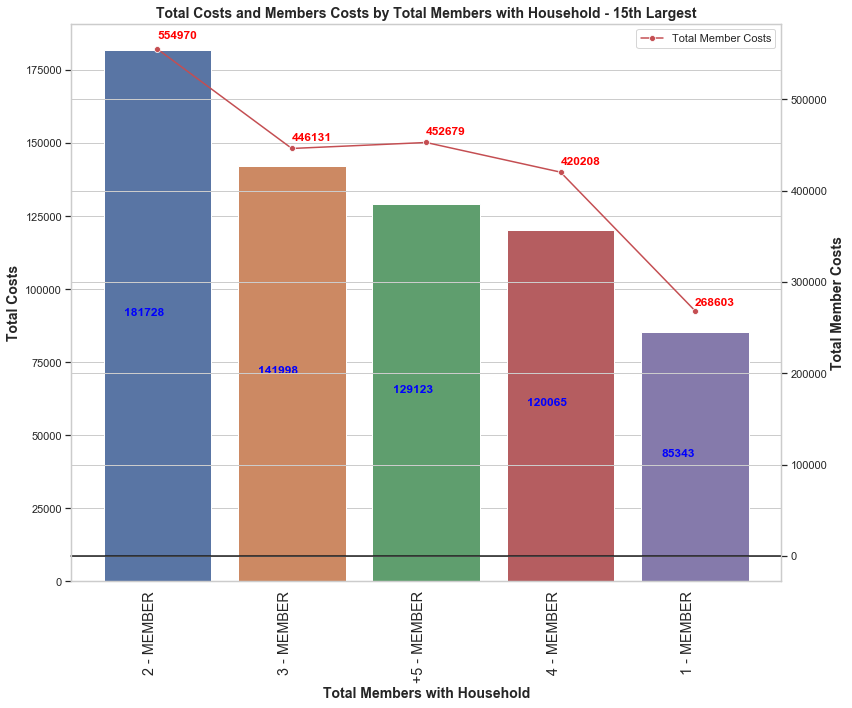

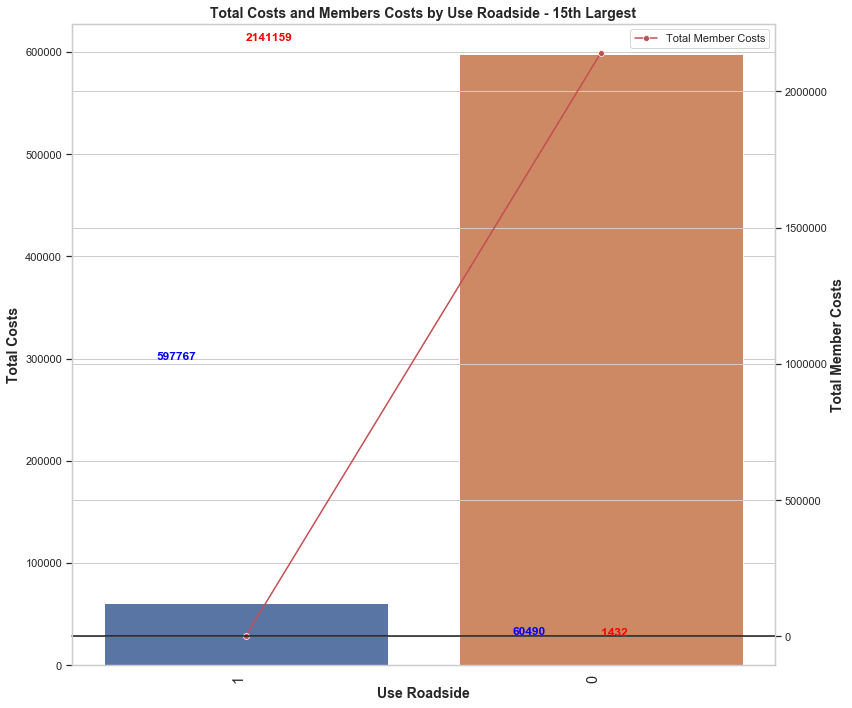

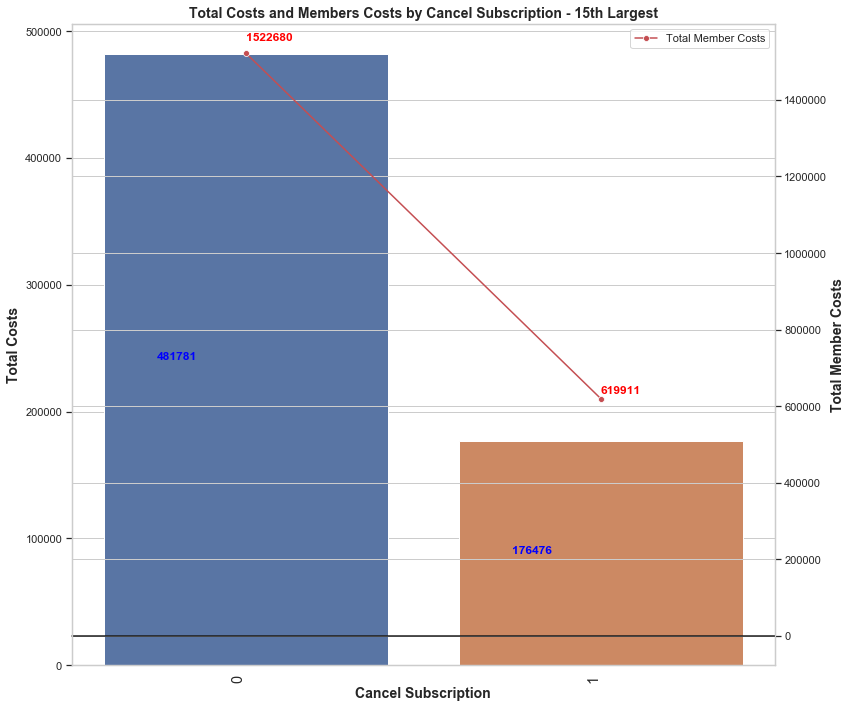

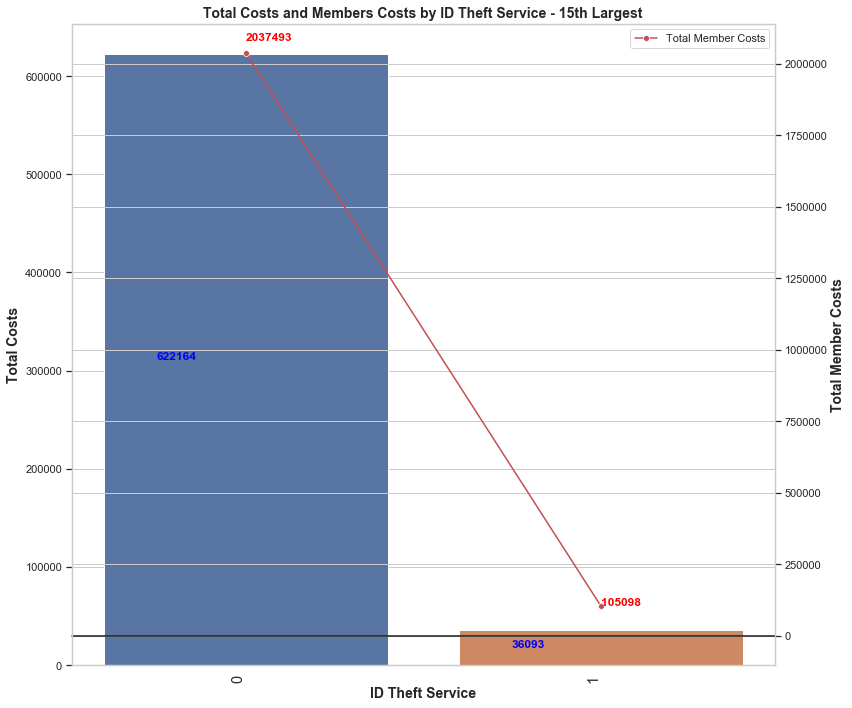

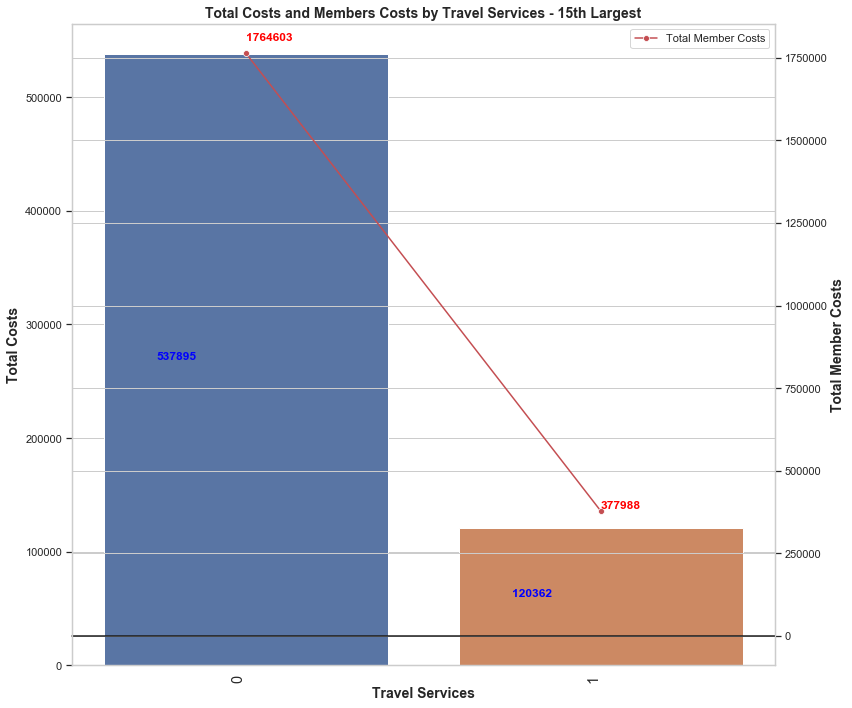

In [70]:
# Columns to plot Total costs and member costs 
cols = [ 'income', 'member_status','state_grouped', 'credit_ranges', 'cancel_reason','renew_method',
        'sc_vehicle_manufacturer_name','sc_vehicle_model_name','race','home_owner','education', 
        'dwelling_type', 'gender','occupation_code', 'occupation_group', 'occupant_type','mosaic_household',
        'mosaic_global_household','kcl_b_ind_mosaicsgrouping', 'plus_indicator_description',
        'tenure', 'generation', 'aaa_mortgage', 'aaa_credit_card',
        'aaa_deposit', 'aaa_home_equity', 'aaa_financial_service', 'aaa_auto_insurance', 'vehicle',
        'no_members', 'use_road_side', 'aaa_cancel', 'aaa_id_theft', 'aaa_travel'
       ]

# Dictionary for X Axis Labels
dict_cols = { 'income':'Income', 'member_status':'Member Status','state_grouped': 'State', 'credit_ranges':'Credit Range',
             'cancel_reason':'Cancel Reason','renew_method':'Renewal Method','sc_vehicle_manufacturer_name':'Vehicle Manufacturer',
             'sc_vehicle_model_name':'Vehicle Model','race': 'Ethnic Group','home_owner': 'Home Owner','education':'Education Level', 
             'dwelling_type': 'Dwelling Type', 'gender':'Gender','occupation_code':'Occupation', 'occupation_group':'Occupation Group',
             'occupant_type': 'Occupant Type','mosaic_household':'Mosaic household','mosaic_global_household':'Global Mosaic',
             'kcl_b_ind_mosaicsgrouping':'Mosaic Grouping', 'plus_indicator_description':'Membership Type','tenure':'tenure Range', 'generation':'Generation', 
             'aaa_mortgage':'Used Mortgage Service', 'aaa_credit_card':'Use Credit Card Service','aaa_deposit':'Use Deposit Service',
             'aaa_home_equity':'Use Home Equity Service', 'aaa_financial_service':'Use Financial Service', 
             'aaa_auto_insurance':'Use Insurance Service', 'vehicle':'Vehicle', 'total_cost':'Total Costs',
             'total_calls':'Total Breakdown Calls', 'total_member_cost':'Total Member Costs',
             'no_members':'Total Members with Household', 'aaa_id_theft':'ID Theft Service', 'aaa_travel':'Travel Services',
             'use_road_side':'Use Roadside',  'aaa_cancel' : 'Cancel Subscription', '0' :'No', '1':'Yes',
            }

cols2 = 'total_cost'
cols3 = 'total_member_cost'

for col in cols:
    
    df_cols = [col, cols2, cols3]
    df = pd.DataFrame(data=df_feature,columns=df_cols)
    df[cols2] = df[cols2].apply(lambda x: int(x))
    df[cols3] = df[cols3].apply(lambda x: int(x))
    df = df.groupby(by=col, axis=0, level=None, as_index=False, 
                    sort=True, group_keys=True, 
                    squeeze=True,observed=False,).sum().nlargest(15,cols2)
    df.sort_values(by=cols2, ascending=False,inplace=True)
    
    fig, ax1 = plt.subplots()
    sns.set(style="whitegrid")
    ax2 = ax1.twinx()
    sns.barplot(df[col], df[cols2], ax=ax1)
    # Show values at the bottom of each bar graph
    i = 0
    for v in list(df[cols2]):
        ax1.text(i-.25, v/2, str(int(v)), color='blue', fontweight='bold')
        i +=1
    # Draw a line plot using a second axis
    sns.lineplot(x=df[col],y=df[cols3], color="r", marker="o", ax=ax2, sort=False)
    i = 0
    for v in list(df[cols3]):
        ax2.text(i, v/0.98, str(int(v)), color='red', fontweight='bold')
        i +=1
    
    ax1.set_ylabel(dict_cols[cols2],fontsize=14, fontweight='bold')
    ax1.set_xlabel(dict_cols[col],fontsize=14, fontweight='bold')
    ax1.set_xticklabels(df[col],rotation=90, horizontalalignment='right', fontweight='light', fontsize='large')
    
    ax2.set_ylabel(dict_cols[cols3],fontsize=14, fontweight='bold')
    ax2.legend(labels=[dict_cols[cols3]], loc='upper right')
              
    plt.axhline(0, color="k", clip_on=False)
    plt.title('Total Costs and Members Costs by '+ dict_cols[col] + ' - 15th Largest',loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
    # Save image
    image_name='./pics/Total Costs and Members Costs by '+ dict_cols[col]+ ' - 15th Largest - Bar Chart.png'
    plt.savefig(image_name)
    plt.show()
    df['Total Profit (3 yrs)'] = np.round(df['total_member_cost'] - df['total_cost'],2)
    df.rename(columns={col: dict_cols[col], 'total_cost': "Total Costs", 'total_member_cost':'Total Member Costs'}, inplace=True)
    fig = ff.create_table(df, height_constant=30, index=False)
    py.iplot(fig)
    image_name='./pics/Total Costs and Members Costs by '+dict_cols[col]+ ' - 15th Largest - Table.png'
    fig.write_image(image_name)

In [ ]:
# Heatmap with Seaborn - Total Costs
cols1 = [ 'income', 'member_status','state_grouped', 'credit_ranges', 'cancel_reason','renew_method',
        'sc_vehicle_manufacturer_name','sc_vehicle_model_name','race','home_owner','education', 
        'dwelling_type', 'gender','occupation_code', 'occupation_group', 'occupant_type','mosaic_household',
        'mosaic_global_household','kcl_b_ind_mosaicsgrouping', 'plus_indicator_description', 
        'tenure', 'generation', 'aaa_mortgage', 'aaa_credit_card', 
        'aaa_deposit', 'aaa_home_equity', 'aaa_financial_service', 'aaa_auto_insurance', 'vehicle'
       ]

cols2 = [ 'income', 'member_status','state_grouped', 'credit_ranges', 'cancel_reason','renew_method',
        'sc_vehicle_manufacturer_name','sc_vehicle_model_name','race','home_owner','education', 
        'dwelling_type', 'gender','occupation_code', 'occupation_group', 'occupant_type','mosaic_household',
        'mosaic_global_household','kcl_b_ind_mosaicsgrouping', 'plus_indicator_description', 
        'tenure', 'generation', 'aaa_mortgage', 'aaa_credit_card', 
        'aaa_deposit', 'aaa_home_equity', 'aaa_financial_service', 'aaa_auto_insurance', 'vehicle'
       ]

# Dictionary for X Axis Labels
dict_cols = { 'income':'Income', 'member_status':'Member Status','state_grouped': 'State', 'credit_ranges':'Credit Range',
             'cancel_reason':'Cancel Reason','renew_method':'Renewal Method','sc_vehicle_manufacturer_name':'Vehicle Manufacturer',
             'sc_vehicle_model_name':'Vehicle Model','race': 'Ethnic Group','home_owner': 'Home Owner','education':'Education Level', 
             'dwelling_type': 'Dwelling Type', 'gender':'Gender','occupation_code':'Occupation', 'occupation_group':'Occupation Group',
             'occupant_type': 'Occupant Type','mosaic_household':'Mosaic household','mosaic_global_household':'Global Mosaic',
             'kcl_b_ind_mosaicsgrouping':'Mosaic Grouping', 'plus_indicator_description':'Membership Type','tenure':'tenure Range', 
             'generation':'Generation', 'aaa_mortgage':'Used Mortgage Service', 'aaa_credit_card':'Use Credit Card Service',
             'aaa_deposit':'Use Deposit Service','aaa_home_equity':'Use Home Equity Service', 'aaa_financial_service':'Use Financial Service', 
             'aaa_auto_insurance':'Use Insurance Service', 'vehicle':'Vehicle', 'total_cost':'Total Costs',
             'total_calls':'Total Breakdown Calls', 'total_member_cost':'Total Member Costs'             
            }

cols3 = 'total_cost'
cols1_cols2_cols3 = [[x[0], x[1], cols3] for x in list(itertools.product(cols1,cols2))]
# Load columns 
# Draw a heatmap with the numeric values in each cell
for i in cols1_cols2_cols3:
    if i[0]==i[1]: continue        
    df = pd.DataFrame(df_feature, columns=i)
    df = df.groupby(by=[i[0], i[1]]).sum()
    df.reset_index(inplace=True)
    df = df.pivot(i[0], i[1], i[2])

    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots()
    ax = sns.heatmap(df, annot=True, fmt=".0f", linewidths=0.1, ax=ax, xticklabels=True, 
                cbar_kws={'label': 'Total Costs'}, yticklabels=True)
    ax.figure.axes[-1].yaxis.label.set_size(14)
    plt.ylabel(dict_cols[i[0]],fontsize=14, fontweight='bold')
    plt.xlabel(dict_cols[i[1]], fontsize=14, fontweight='bold')
    plt.title('HeatMap - '+ dict_cols[i[0]] + ' by '+ dict_cols[i[1]] ,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    image_name='./pics/Total Costs - '+ dict_cols[i[0]] + ' by '+ dict_cols[i[1]] +  '- HeatMap.png'
    plt.savefig(image_name)
    plt.show()

In [ ]:
df.sort_values(by='aaa_auto_insurance',axis=0,
    ascending=False,
    inplace=False,
    kind='quicksort',
    na_position='last',)

In [ ]:
# Heatmap with Seaborn - Total Breakdown calls
cols1 = [ 'income', 'member_status','state_grouped', 'credit_ranges', 'cancel_reason','renew_method',
        'sc_vehicle_manufacturer_name','sc_vehicle_model_name','race','home_owner','education', 
        'dwelling_type', 'gender','occupation_code', 'occupation_group', 'occupant_type','mosaic_household',
        'mosaic_global_household','kcl_b_ind_mosaicsgrouping', 'plus_indicator_description',
        'tenure', 'generation', 'aaa_mortgage', 'aaa_credit_card', 
        'aaa_deposit', 'aaa_home_equity', 'aaa_financial_service', 'aaa_auto_insurance', 'vehicle'
       ]

cols2 = [ 'income', 'member_status','state_grouped', 'credit_ranges', 'cancel_reason','renew_method',
        'sc_vehicle_manufacturer_name','sc_vehicle_model_name','race','home_owner','education', 
        'dwelling_type', 'gender','occupation_code', 'occupation_group', 'occupant_type','mosaic_household',
        'mosaic_global_household','kcl_b_ind_mosaicsgrouping', 'plus_indicator_description',
        'tenure', 'generation', 'aaa_mortgage', 'aaa_credit_card',
        'aaa_deposit', 'aaa_home_equity', 'aaa_financial_service', 'aaa_auto_insurance', 'vehicle'
       ]

# Dictionary for X Axis Labels
dict_cols = { 'income':'Income', 'member_status':'Member Status','state_grouped': 'State', 'credit_ranges':'Credit Range',
             'cancel_reason':'Cancel Reason','renew_method':'Renewal Method','sc_vehicle_manufacturer_name':'Vehicle Manufacturer',
             'sc_vehicle_model_name':'Vehicle Model','race': 'Ethnic Group','home_owner': 'Home Owner','education':'Education Level', 
             'dwelling_type': 'Dwelling Type', 'gender':'Gender','occupation_code':'Occupation', 'occupation_group':'Occupation Group',
             'occupant_type': 'Occupant Type','mosaic_household':'Mosaic household','mosaic_global_household':'Global Mosaic',
             'kcl_b_ind_mosaicsgrouping':'Mosaic Grouping', 'plus_indicator_description':'Membership Type','tenure':'tenure Range', 'generation':'Generation', 
             'aaa_mortgage':'Used Mortgage Service', 'aaa_credit_card':'Use Credit Card Service','aaa_deposit':'Use Deposit Service',
             'aaa_home_equity':'Use Home Equity Service', 'aaa_financial_service':'Use Financial Service', 
             'aaa_auto_insurance':'Use Insurance Service', 'vehicle':'Vehicle', 'total_cost':'Total Costs',
             'total_calls':'Total Breakdown Calls', 'total_member_cost':'Total Member Costs'
             
            }

cols3 = 'total_calls'
cols1_cols2_cols3 = [[x[0], x[1], cols3] for x in list(itertools.product(cols1,cols2))]
# Load columns 
# Draw a heatmap with the numeric values in each cell
for i in cols1_cols2_cols3:
    if i[0]==i[1]: continue        
    df = pd.DataFrame(df_feature, columns=i)
    df = df.groupby(by=[i[0], i[1]]).sum()
    df.reset_index(inplace=True)
    df = df.pivot(i[0], i[1], i[2])

    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots()
    ax = sns.heatmap(df, annot=True, fmt=".0f", linewidths=0.1, ax=ax, 
                cbar_kws={'label': 'Total Breakdown Calls'}, xticklabels=True, yticklabels=True)
    ax.figure.axes[-1].yaxis.label.set_size(14)
    plt.ylabel(dict_cols[i[0]],fontsize=14, fontweight='bold')
    plt.xlabel(dict_cols[i[1]], fontsize=14, fontweight='bold')
    plt.title('HeatMap - '+ dict_cols[i[0]] + ' by '+ dict_cols[i[1]] ,loc='center', 
              fontdict={'fontsize':14, 'fontweight':'bold'}
             )
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    image_name='./pics/Total Breakdown Calls - '+ dict_cols[i[0]] + ' by '+ dict_cols[i[1]] +  '- HeatMap.png'
    plt.savefig(image_name)
    plt.show()

In [ ]:
# Heatmap with Seaborn - Total Member costs
cols1 = [ 'income', 'member_status','state_grouped', 'credit_ranges', 'cancel_reason','renew_method',
        'sc_vehicle_manufacturer_name','sc_vehicle_model_name','race','home_owner','education', 
        'dwelling_type', 'gender','occupation_code', 'occupation_group', 'occupant_type','mosaic_household',
        'mosaic_global_household','kcl_b_ind_mosaicsgrouping', 'plus_indicator_description',
        'tenure', 'generation', 'aaa_mortgage', 'aaa_credit_card', 
        'aaa_deposit', 'aaa_home_equity', 'aaa_financial_service', 'aaa_auto_insurance', 'vehicle'
       ]

cols2 = [ 'income', 'member_status','state_grouped', 'credit_ranges', 'cancel_reason','renew_method',
        'sc_vehicle_manufacturer_name','sc_vehicle_model_name','race','home_owner','education', 
        'dwelling_type', 'gender','occupation_code', 'occupation_group', 'occupant_type','mosaic_household',
        'mosaic_global_household','kcl_b_ind_mosaicsgrouping', 'plus_indicator_description',
        'tenure', 'generation', 'aaa_mortgage', 'aaa_credit_card',
        'aaa_deposit', 'aaa_home_equity', 'aaa_financial_service', 'aaa_auto_insurance', 'vehicle'
       ]

# Dictionary for X Axis Labels
dict_cols = { 'income':'Income', 'member_status':'Member Status','state_grouped': 'State', 'credit_ranges':'Credit Range',
             'cancel_reason':'Cancel Reason','renew_method':'Renewal Method','sc_vehicle_manufacturer_name':'Vehicle Manufacturer',
             'sc_vehicle_model_name':'Vehicle Model','race': 'Ethnic Group','home_owner': 'Home Owner','education':'Education Level', 
             'dwelling_type': 'Dwelling Type', 'gender':'Gender','occupation_code':'Occupation', 'occupation_group':'Occupation Group',
             'occupant_type': 'Occupant Type','mosaic_household':'Mosaic household','mosaic_global_household':'Global Mosaic',
             'kcl_b_ind_mosaicsgrouping':'Mosaic Grouping', 'plus_indicator_description':'Membership Type','tenure':'tenure Range', 'generation':'Generation', 
             'aaa_mortgage':'Used Mortgage Service', 'aaa_credit_card':'Use Credit Card Service','aaa_deposit':'Use Deposit Service',
             'aaa_home_equity':'Use Home Equity Service', 'aaa_financial_service':'Use Financial Service', 
             'aaa_auto_insurance':'Use Insurance Service', 'vehicle':'Vehicle', 'total_cost':'Total Costs',
             'total_calls':'Total Breakdown Calls', 'total_member_cost':'Total Member Costs'
             
            }

cols3 = 'total_member_cost'
cols1_cols2_cols3 = [[x[0], x[1], cols3] for x in list(itertools.product(cols1,cols2))]
# Load columns 
# Draw a heatmap with the numeric values in each cell
for i in cols1_cols2_cols3:
    if i[0]==i[1]: continue        
    df = pd.DataFrame(df_feature, columns=i)
    df = df.groupby(by=[i[0], i[1]]).sum()
    df.reset_index(inplace=True)
    df = df.pivot(i[0], i[1], i[2])

    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots()
    ax = sns.heatmap(df, annot=True, fmt=".0f", linewidths=0.1, ax=ax, 
                cbar_kws={'label': 'Total Member Costs'}, xticklabels=True, yticklabels=True)
    ax.figure.axes[-1].yaxis.label.set_size(14)
    plt.ylabel(dict_cols[i[0]],fontsize=14, fontweight='bold')
    plt.xlabel(dict_cols[i[1]], fontsize=14, fontweight='bold')
    plt.title('HeatMap - '+ dict_cols[i[0]] + ' by '+ dict_cols[i[1]] ,loc='center', 
              fontdict={'fontsize':14, 'fontweight':'bold'}
             )
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    image_name='./pics/Total Member Costs - '+ dict_cols[i[0]] + ' by '+ dict_cols[i[1]] +  '- HeatMap.png'
    plt.savefig(image_name)
    plt.show()

In [ ]:
# Line Graph with total costs and Total Breakdown  
cols1 = [ 'income', 'member_status','state_grouped', 'credit_ranges', 'cancel_reason','renew_method',
        'sc_vehicle_manufacturer_name','sc_vehicle_model_name','race','home_owner','education', 
        'dwelling_type', 'gender','occupation_code', 'occupation_group', 'occupant_type','mosaic_household',
        'mosaic_global_household','kcl_b_ind_mosaicsgrouping', 'plus_indicator_description',
        'tenure', 'generation', 'aaa_mortgage', 'aaa_credit_card',
        'aaa_deposit', 'aaa_home_equity', 'aaa_financial_service', 'aaa_auto_insurance', 'vehicle'
       ]

# Dictionary for X Axis Labels
dict_cols = { 'income':'Income', 'member_status':'Member Status','state_grouped': 'State', 'credit_ranges':'Credit Range',
             'cancel_reason':'Cancel Reason','renew_method':'Renewal Method','sc_vehicle_manufacturer_name':'Vehicle Manufacturer',
             'sc_vehicle_model_name':'Vehicle Model','race': 'Ethnic Group','home_owner': 'Home Owner','education':'Education Level', 
             'dwelling_type': 'Dwelling Type', 'gender':'Gender','occupation_code':'Occupation', 'occupation_group':'Occupation Group',
             'occupant_type': 'Occupant Type','mosaic_household':'Mosaic household','mosaic_global_household':'Global Mosaic',
             'kcl_b_ind_mosaicsgrouping':'Mosaic Grouping', 'plus_indicator_description':'Membership Type','tenure':'tenure Range', 'generation':'Generation', 
             'aaa_mortgage':'Used Mortgage Service', 'aaa_credit_card':'Use Credit Card Service','aaa_deposit':'Use Deposit Service',
             'aaa_home_equity':'Use Home Equity Service', 'aaa_financial_service':'Use Financial Service', 
             'aaa_auto_insurance':'Use Insurance Service', 'vehicle':'Vehicle', 'total_cost':'Total Costs', 
             'total_calls':'Total Breakdown Calls', 'total_member_cost':'Total Member Avg. Costs'             
            }

cols2 = 'total_cost'
cols3 = 'total_calls'

# Draw a line plot with the numeric values in each cell
for i in cols1:
    df_cols =  [i, cols2, cols3]
    df = pd.DataFrame(data=df_feature,columns=df_cols)
    df[cols2] = df[cols2].apply(lambda x: int(x))
    df = df.groupby(by=i, axis=0, level=None, as_index=False, sort=True, group_keys=True, squeeze=True,observed=False,).sum()
    df.sort_values(by=cols2, ascending=False,inplace=True)
    # Just to show the Top 30
    df = df.sort_values(by=cols2, ascending=False)[:30].reset_index(drop=True)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    sns.lineplot(x=df[i], y=df[cols3], color="r", legend='full', marker="x", ax=ax1)
    sns.lineplot(data=df[cols2], color="b", marker="o", ax=ax2)
    ax1.set_ylabel(dict_cols[cols3],fontsize=14, fontweight='bold')
    ax1.set_xlabel(dict_cols[i],fontsize=14, fontweight='bold')
    ax1.set_xticklabels(df[i],rotation=90)
    ax1.legend(labels=['Total Breakdown Calls'], loc='upper left')
    ax2.set_ylabel(dict_cols[cols2],fontsize=14, fontweight='bold')
    ax2.legend(labels=['Total Costs'], loc='upper right')
    
    
    plt.title('Line Plot - Total Costs & Total Breakdown Calls by '+ dict_cols[i],loc='center', 
              fontdict={'fontsize':14, 'fontweight':'bold'}
             )
    image_name='./pics/Total Costs and Breakdown Calls - by '+ dict_cols[i] +  '- Lineplot.png'
    plt.savefig(image_name)
    plt.show()

In [ ]:
# Line Graph with total costs and Total member costs  
cols1 = [ 'income', 'member_status','state_grouped', 'credit_ranges', 'cancel_reason','renew_method',
        'sc_vehicle_manufacturer_name','sc_vehicle_model_name','race','home_owner','education', 
        'dwelling_type', 'gender','occupation_code', 'occupation_group', 'occupant_type','mosaic_household',
        'mosaic_global_household','kcl_b_ind_mosaicsgrouping', 'plus_indicator_description',
        'tenure', 'generation', 'aaa_mortgage', 'aaa_credit_card',
        'aaa_deposit', 'aaa_home_equity', 'aaa_financial_service', 'aaa_auto_insurance', 'vehicle'
       ]

# Dictionary for X Axis Labels
dict_cols = { 'income':'Income', 'member_status':'Member Status','state_grouped': 'State', 'credit_ranges':'Credit Range',
             'cancel_reason':'Cancel Reason','renew_method':'Renewal Method','sc_vehicle_manufacturer_name':'Vehicle Manufacturer',
             'sc_vehicle_model_name':'Vehicle Model','race': 'Ethnic Group','home_owner': 'Home Owner','education':'Education Level', 
             'dwelling_type': 'Dwelling Type', 'gender':'Gender','occupation_code':'Occupation', 'occupation_group':'Occupation Group',
             'occupant_type': 'Occupant Type','mosaic_household':'Mosaic household','mosaic_global_household':'Global Mosaic',
             'kcl_b_ind_mosaicsgrouping':'Mosaic Grouping', 'plus_indicator_description':'Membership Type','tenure':'tenure Range', 'generation':'Generation', 
             'aaa_mortgage':'Used Mortgage Service', 'aaa_credit_card':'Use Credit Card Service','aaa_deposit':'Use Deposit Service',
             'aaa_home_equity':'Use Home Equity Service', 'aaa_financial_service':'Use Financial Service', 
             'aaa_auto_insurance':'Use Insurance Service', 'vehicle':'Vehicle', 'total_cost':'Total Costs', 
             'total_calls':'Total Breakdown Calls', 'total_member_cost':'Total Member Costs'             
            }

cols2 = 'total_cost'
cols3 = 'total_member_cost'

# Draw a line plot with the numeric values in each cell
for i in cols1:
    df_cols =  [i, cols2, cols3]
    df = pd.DataFrame(data=df_feature,columns=df_cols)
    df[cols2] = df[cols2].apply(lambda x: int(x))
    df = df.groupby(by=i, axis=0, level=None, as_index=False, sort=True, group_keys=True, squeeze=True,observed=False,).sum()
    df.sort_values(by=cols2, ascending=False,inplace=True)
    # Just to show the Top 30
    df = df.sort_values(by=cols2, ascending=False)[:30].reset_index(drop=True)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    sns.lineplot(x=df[i], y=df[cols3], color="r", legend='full', marker="x", ax=ax1)
    sns.lineplot(data=df[cols2], color="b", marker="o", ax=ax2, sort=False)
    ax1.set_ylabel(dict_cols[cols3],fontsize=14, fontweight='bold')
    ax1.set_xlabel(dict_cols[i],fontsize=14, fontweight='bold')
    ax1.set_xticklabels(df[i],rotation=90)
    ax1.legend(labels=[dict_cols[cols3]], loc='upper left')
    ax2.set_ylabel(dict_cols[cols2],fontsize=14, fontweight='bold')
    ax2.legend(labels=[dict_cols[cols2]], loc='upper right')
        
    plt.title('Line Plot - Total Costs & Total Member Costs by '+ dict_cols[i],loc='center', 
              fontdict={'fontsize':14, 'fontweight':'bold'}
             )
    image_name='./pics/Total Costs and Breakdown Calls - by '+ dict_cols[i] +  '- Lineplot.png'
    plt.savefig(image_name)
    plt.show()

In [ ]:
# Line Graph with total costs and Total Breakdown  - Problem Codes
cols1 = ['clearing_code_last_description', 'dispatch_code1_description', 'prob1_code_description', 
         'sc_sts_rsn_code_description'
       ]

# Dictionary for X Axis Labels
dict_cols = { 'clearing_code_last_description':'Clearing Code Description', 'dispatch_code1_description':'Dispatch Code Description',
             'prob1_code_description':'Problem Description','total_cost':'Total Costs', 'total_calls':'Total Breakdown Calls',
             'sc_sts_rsn_code_description':'Service Type'
            }

cols2 = 'total_cost'
cols3 = 'total_calls'

# Draw a line plot with the numeric values in each cell
for i in cols1:
    df_cols =  [i, cols2, cols3]
    df = pd.DataFrame(data=df_capstone_aaa_f,columns=df_cols)
    df[cols2] = df[cols2].apply(lambda x: int(x))
    df = df.groupby(by=i, axis=0, level=None, as_index=False, sort=True, group_keys=True, squeeze=True,observed=False,).sum()
    df.sort_values(by=cols2, ascending=False,inplace=True)
    # Just to show the Top 30
    df = df = df.sort_values(by=cols2, ascending=False)[:30].reset_index(drop=True)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    sns.lineplot(x=df[i], y=df[cols3], color="r", legend='full', marker="x", ax=ax1)
    sns.lineplot(data=df[cols2], color="b", marker="o", ax=ax2)
    ax1.set_ylabel(dict_cols[cols3],fontsize=14, fontweight='bold')
    ax1.set_xlabel(dict_cols[i],fontsize=14, fontweight='bold')
    ax1.set_xticklabels(df[i],rotation=90)
    ax1.legend(labels=['Total Breakdown Calls'], loc='upper left')
    ax2.set_ylabel(dict_cols[cols2],fontsize=14, fontweight='bold')
    ax2.legend(labels=['Total Costs'], loc='upper right')
    
    
    plt.title('Line Plot - Total Costs & Total Breakdown Calls by '+ dict_cols[i],loc='center', 
              fontdict={'fontsize':14, 'fontweight':'bold'}
             )
    image_name='./pics/Total Costs and Breakdown Calls - by '+ dict_cols[i] +  '- Lineplot.png'
    plt.savefig(image_name)
    plt.show()
    break

In [ ]:
df

In [ ]:
# Heatmaps with Plotly
dict_cols = { 'income':'Income', 'member_status':'Member Status','state_grouped': 'State', 'credit_ranges':'Credit Range',
             'cancel_reason':'Cancel Reason','renew_method':'Renewal Method','sc_vehicle_manufacturer_name':'Vehicle Manufacturer',
             'sc_vehicle_model_name':'Vehicle Model','race': 'Ethnic Group','home_owner': 'Home Owner','education':'Education Level', 
             'dwelling_type': 'Dwelling Type', 'gender':'Gender','occupation_code':'Occupation', 'occupation_group':'Occupation Group',
             'occupant_type': 'Occupant Type','mosaic_household':'Mosaic household','mosaic_global_household':'Global Mosaic',
             'kcl_b_ind_mosaicsgrouping':'Mosaic Grouping', 'plus_indicator_description':'Membership Type','tenure':'tenure Range', 'generation':'Generation', 
             'aaa_mortgage':'Used Mortgage Service', 'aaa_credit_card':'Use Credit Card Service','aaa_deposit':'Use Deposit Service',
             'aaa_home_equity':'Use Home Equity Service', 'aaa_financial_service':'Use Financial Service', 
             'aaa_auto_insurance':'Use Insurance Service', 'vehicle':'Vehicle'             
            }

cols1 = [ 'income', 'member_status','state_grouped', 'credit_ranges', 'cancel_reason','renew_method',
        'sc_vehicle_manufacturer_name','sc_vehicle_model_name','race','home_owner','education', 
        'dwelling_type', 'gender','occupation_code', 'occupation_group', 'occupant_type','mosaic_household',
        'mosaic_global_household','kcl_b_ind_mosaicsgrouping', 'plus_indicator_description',
        'tenure', 'generation', 'aaa_mortgage', 'aaa_credit_card',
        'aaa_deposit', 'aaa_home_equity', 'aaa_financial_service', 'aaa_auto_insurance', 'vehicle'
       ]

cols2 = [ 'income', 'member_status','state_grouped', 'credit_ranges', 'cancel_reason','renew_method',
        'sc_vehicle_manufacturer_name','sc_vehicle_model_name','race','home_owner','education', 
        'dwelling_type', 'gender','occupation_code', 'occupation_group', 'occupant_type','mosaic_household',
        'mosaic_global_household','kcl_b_ind_mosaicsgrouping', 'plus_indicator_description',
        'tenure', 'generation', 'aaa_mortgage', 'aaa_credit_card',
        'aaa_deposit', 'aaa_home_equity', 'aaa_financial_service', 'aaa_auto_insurance', 'vehicle'
       ]

cols3 = 'total_cost'

cols1_cols2_cols3 = [[x[0], x[1], cols3] for x in list(itertools.product(cols1,cols2))]
for i in cols1_cols2_cols3:
    if i[0]==i[1]: continue        
    fig = go.Figure(data=go.Heatmap(z=df_feature[i[2]].dropna(), x=df_feature[i[0]].dropna(), y=df_feature[i[1]].dropna(),
                                    autocolorscale = True, colorscale='Viridis'
                                   )
                   )    
    fig.update_layout(title='Total Costs HeatMap - AAA - '+ dict_cols[i[0]] + ' vs. ' + dict_cols[i[1]],  xaxis_nticks=36,
                      xaxis_title=dict_cols[i[0]],
                      yaxis_title=dict_cols[i[1]]
                     )
    fig.show()

In [ ]:
# Heatmaps with Plotly
dict_cols = { 'income':'Income', 'member_status':'Member Status','state_grouped': 'State', 'credit_ranges':'Credit Range',
             'cancel_reason':'Cancel Reason','renew_method':'Renewal Method','sc_vehicle_manufacturer_name':'Vehicle Manufacturer',
             'sc_vehicle_model_name':'Vehicle Model','race': 'Ethnic Group','home_owner': 'Home Owner','education':'Education Level', 
             'dwelling_type': 'Dwelling Type', 'gender':'Gender','occupation_code':'Occupation', 'occupation_group':'Occupation Group',
             'occupant_type': 'Occupant Type','mosaic_household':'Mosaic household','mosaic_global_household':'Global Mosaic',
             'kcl_b_ind_mosaicsgrouping':'Mosaic Grouping', 'plus_indicator_description':'Membership Type','tenure':'tenure Range', 'generation':'Generation', 
             'aaa_mortgage':'Used Mortgage Service', 'aaa_credit_card':'Use Credit Card Service','aaa_deposit':'Use Deposit Service',
             'aaa_home_equity':'Use Home Equity Service', 'aaa_financial_service':'Use Financial Service', 
             'aaa_auto_insurance':'Use Insurance Service', 'vehicle':'Vehicle'             
            }

cols1 = [ 'income', 'member_status','state_grouped', 'credit_ranges', 'cancel_reason','renew_method',
        'sc_vehicle_manufacturer_name','sc_vehicle_model_name','race','home_owner','education', 
        'dwelling_type', 'gender','occupation_code', 'occupation_group', 'occupant_type','mosaic_household',
        'mosaic_global_household','kcl_b_ind_mosaicsgrouping', 'plus_indicator_description',
        'tenure', 'generation', 'aaa_mortgage', 'aaa_credit_card',
        'aaa_deposit', 'aaa_home_equity', 'aaa_financial_service', 'aaa_auto_insurance', 'vehicle'
       ]

cols2 = [ 'income', 'member_status','state_grouped', 'credit_ranges', 'cancel_reason','renew_method',
        'sc_vehicle_manufacturer_name','sc_vehicle_model_name','race','home_owner','education', 
        'dwelling_type', 'gender','occupation_code', 'occupation_group', 'occupant_type','mosaic_household',
        'mosaic_global_household','kcl_b_ind_mosaicsgrouping', 'plus_indicator_description',
        'tenure', 'generation', 'aaa_mortgage', 'aaa_credit_card',
        'aaa_deposit', 'aaa_home_equity', 'aaa_financial_service', 'aaa_auto_insurance', 'vehicle'
       ]

cols3 = 'total_calls'

cols1_cols2_cols3 = [[x[0], x[1], cols3] for x in list(itertools.product(cols1,cols2))]
for i in cols1_cols2_cols3:
    if i[0]==i[1]: continue        
    fig = go.Figure(data=go.Heatmap(z=df_feature[i[2]].dropna(), x=df_feature[i[0]].dropna(), y=df_feature[i[1]].dropna(),
                                    autocolorscale = True, colorscale='Viridis'
                                   )
                   )    
    fig.update_layout(title='Total BreakDown Calls HeatMap - AAA - '+ dict_cols[i[0]] + ' vs. ' + dict_cols[i[1]],  xaxis_nticks=36,
                      xaxis_title=dict_cols[i[0]],
                      yaxis_title=dict_cols[i[1]]
                     )
    fig.show()
    